# A/B Testing PSM Uplift 


### *A/B Testing with Propensity Scores & Uplift (PSM / IPW / Matching)*

**Purpose.** Estimate the causal impact of a treatment on key outcomes and read out **uplift overall and by customer segment**.  
We use **propensity scores** to adjust for selection, compute **IPW ATE/ATT**, add a **nearest-neighbor matching** robustness check, and include **diagnostics** (overlap, balance).


### What you need (inputs)

- **Experiment table** `data/experiment.csv`  
  Columns (minimum):  
  - `user_id` (id), `treatment` (0/1)  
  - ≥1 **outcome**: e.g. `any_reorder_post` (binary), `items_post` (continuous)  
  - **covariates (pre-period only)**: e.g. `reorder_rate_pre`, `total_prior_orders`, `avg_basket_pre`, `unique_products_pre`, `avg_days_between_pre`, plus optional categorical like `segment`  
- **Segments** *(optional but recommended)*: `data/segments.csv` or `data/customer_segments.csv` with columns: `user_id`, `segment`

**Data contracts:** No post-period info is allowed in covariates used for propensity modeling.


### What you get (outputs)

- **Tables**
  - `artifacts/ab_overall_readout.csv` — overall ATE/ATT (IPW + Matching)
  - `artifacts/ab_results_by_segment.csv` — ATE by segment (+95% CI)
  - `artifacts/pscores_train_test.csv` — pscores by split
  - `artifacts/balance_smd_test.csv` — SMDs before/after IPW
- **Figures** (also copied to `artifacts/figures/`)
  - `ps_overlap_train.png`, `ps_overlap_test.png` — propensity overlap
  - `uplift_by_segment(_ipw).png` — by-segment uplift with 95% CI
- **Diagnostics**
  - `artifacts/diagnostics.json` — sample sizes, mean pscore, SMD summary, CS window, QA flags
  - `artifacts/findings_actions.md` — final summary block


### Run order (cells)

1. **00 — Imports & Paths**  
2. **Build/Load** experiment + segments → `data/experiment.csv`  
3. **QC**: schema, nulls, duplicates, treatment mix, segment coverage  
4. **Step 1 — Train/Test split & PS model**  
   - Robust covariate selection, impute/scale/one-hot, fit logistic PS, get AUC  
   - Save `train_df`, `test_df`, `ps_diag`  
5. **Time Series (optional)**: daily/weekly series + temporal splits (Train/Val/Test)  
6. **Step 3 — Propensity Scores**  
   - Clip to `[0.01, 0.99]`, **overlap plots**, **SMDs pre/post IPW**  
7. **Step 4 — Causal Estimation**  
   - **IPW (stabilized) ATE/ATT** + bootstrap CIs (TEST, common support)  
   - **Matching (1:1 NN, caliper)** ATT + fast paired-bootstrap CIs  
   - **By-segment uplift** (+95% CIs, tiny-n filtered)  
8. **Sanity & Checks (QA)**  
   - Overlap near 0/1 small; SMDs improved; IPW vs Matching same direction; small segments hidden  
9. **Step 5 — Readout & Artifacts**  
   - Save consolidated tables/figures/diagnostics  
10. **Findings & Actions** (editable summary)


### Key parameters (change here if needed)

- **Random seed:** `RANDOM_SEED`  
- **Propensity clipping:** `CLIP_LO=0.01`, `CLIP_HI=0.99`  
- **Common support window:** automatic from overlap (default trims to 1–99%); override with `LO`, `HI`  
- **By-segment minimum n:** `MIN_TREAT`, `MIN_CTRL` (e.g., 20 each)  
- **Matching:** `use_logit=True`, `caliper=0.2` (≈ 0.2×SD of logit(ps)), `with_replacement=True`


### Methods (one-liner recap)

- **Propensity model:** Logistic regression approximating \( p_i = P(T=1 \mid X_i) \)  
- **IPW (stabilized):**  
  - ATE weights: \( w_i = \pi/p_i \) if \(T_i=1\); \( (1-\pi)/(1-p_i) \) if \(T_i=0\)  
  - ATT weights: \( w_i = 1 \) if treated; \( (p_i/(1-p_i))\cdot((1-\pi)/\pi) \) if control  
- **Matching:** 1:1 nearest neighbor on logit(ps), optional caliper; ATT on matched pairs  
- **Uncertainty:** nonparametric bootstrap (overall) or paired bootstrap (matches)


### Guardrails & assumptions

- **No leakage:** Only **pre-period** covariates in PS model.  
- **Overlap:** Inspect histograms; **clip** and **trim common support** before effect estimation.  
- **Balance:** Require SMD improvement post IPW; flag worst covariates.  
- **Small segments:** Hide/flag segments with low treated/control counts.  
- **Interpretation:** Binary outcomes → difference in probabilities; continuous → difference in means.


### Quickstart checklist

- [ ] `data/experiment.csv` exists and has `user_id`, `treatment`, ≥1 outcome, pre-period covariates  
- [ ] (Optional) `data/segments.csv` exists with `user_id`, `segment`  
- [ ] Run **Step 1** → see **AUC** printed  
- [ ] Run **Step 3** → **overlap plots** + **SMD table** saved  
- [ ] Run **Step 4** → **overall ATE/ATT** and **by-segment** tables/figures saved  
- [ ] Run **QA** → all checks! (or acknowledged)  
- [ ] Finish with **Findings & Actions**

*Tip: All saved artifacts land in `artifacts/` so other notebooks (e.g., 06 Reporting) can load them directly.*


## Data Access & Targets

**Purpose.** Define the data sources this notebook reads, the contracts we rely on, and the artifacts we write.

#### Sources (read-only)

| Name | Path (default) | Key fields | Notes |
|---|---|---|---|
| Experiment table | `data/experiment.csv` | `user_id`, `treatment` (0/1), outcomes (e.g., `any_reorder_post`, `items_post`) | Built upstream from Instacart-style raws; **pre-period covariates only**. |
| Segments (optional) | `data/segments.csv` or `data/customer_segments.csv` | `user_id`, `segment` | Used only for slicing uplift; not used to assign treatment. |

- **Data contract:** Covariates used in propensity modeling **must be pre-period** (no leakage).
- **Join key:** `user_id` (1:1 from segments into experiment).

#### Targets (artifacts written)

| Artifact | Path | Description |
|---|---|---|
| Overall readout | `artifacts/ab_overall_readout.csv` | ATE/ATT (IPW stabilized) + ATT (matching). |
| By-segment uplift | `artifacts/ab_results_by_segment.csv` | ATE by `segment` with 95% CIs (filtered for tiny n). |
| Propensity scores | `artifacts/pscores_train_test.csv` | P(T=1\|X) for train/test splits (clipped). |
| Balance diagnostics | `artifacts/balance_smd_test.csv` | SMDs before vs after IPW. |
| Figures | `artifacts/figures/*` | PS overlap, by-segment uplift bars (+CI). |
| QA & summary | `artifacts/diagnostics.json`, `artifacts/findings_actions.md` | QA flags, key numbers, and action items. |

#### Guardrails

- **Overlap:** Clip pscores to `[0.01, 0.99]`; trim to common support before effects.  
- **Balance:** Expect SMDs to improve post-IPW; flag worst offenders.  
- **Segments:** Hide/flag segments with small sample (min treated/controls).  
- **Repro:** `RANDOM_SEED` fixed; paths configurable at the top of the notebook.

In [47]:
# Imports & Config
import re
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown, display
from shutil import copy2

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors


# nicer displays
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
warnings.filterwarnings("ignore")

# plotting defaults (keeps your other notebooks consistent)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# resolve project root if running from Notebooks/
CWD = Path.cwd()
PROJECT_ROOT = CWD.parent if CWD.name.lower() == "notebooks" else CWD
print("PROJECT_ROOT →", PROJECT_ROOT)

SEGMENT_CANDIDATES = [
    PROJECT_ROOT / "data" / "segments.csv",
    PROJECT_ROOT / "data" / "customer_segments.csv",
]
seg_path = next((p for p in SEGMENT_CANDIDATES if p.exists()), None)

if seg_path:
    seg = pd.read_csv(seg_path, usecols=["user_id","segment"])
    exp = exp.merge(seg, on="user_id", how="left")
    exp["segment"] = exp["segment"].astype(str).fillna("Unknown")
    print(f"Merged segments: {seg_path.name} → exp (segments={exp['segment'].nunique()})")
else:
    exp["segment"] = "ALL"  # safe default so downstream plots don’t break
    print("No segments file found → using segment='ALL'")

PROJECT_ROOT → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior
No segments file found → using segment='ALL'


In [48]:
# Deterministic Builder

# Assumes you already ran 00A which defines PROJECT_ROOT
ROOT = PROJECT_ROOT
ORDERS_CLEAN = ROOT / "datasets" / "clean" / "orders_clean.csv"
OP_CLEAN     = ROOT / "datasets" / "clean" / "order_products_clean.csv"
SEGMENTS_CSV = ROOT / "artifacts" / "customer_segments.csv"
OUT_PATH     = ROOT / "data" / "experiment.csv"

# ensure output dirs
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
(SEGMENTS_CSV.parent).mkdir(parents=True, exist_ok=True)

# Load the clean files (preferred) or fall back to raw names in datasets
if ORDERS_CLEAN.exists() and OP_CLEAN.exists():
    orders = pd.read_csv(ORDERS_CLEAN)
    op     = pd.read_csv(OP_CLEAN)
    print(f"Using: {ORDERS_CLEAN.name}, {OP_CLEAN.name}")
else:
    # fallback to raw (non-clean) names
    ORDERS_RAW = ROOT / "datasets" / "instacart_orders.csv"
    OP_RAW     = ROOT / "datasets" / "order_products.csv"
    if not (ORDERS_RAW.exists() and OP_RAW.exists()):
        raise FileNotFoundError(
            "Could not find clean or raw Instacart files.\n"
            f"Expected either:\n - {ORDERS_CLEAN}\n - {OP_CLEAN}\n"
            f"or:\n - {ORDERS_RAW}\n - {OP_RAW}\n"
            "Put the files there or edit the paths above."
        )
    orders = pd.read_csv(ORDERS_RAW)
    op     = pd.read_csv(OP_RAW)
    print(f"Using: {ORDERS_RAW.name}, {OP_RAW.name}")

# Minimal manual renames if someone used different headers 
rename_orders = {}
for cand in ("userId","UserId","customer_id","cust_id","uid"):
    if cand in orders.columns: rename_orders[cand] = "user_id"
for cand in ("orderId","OrderId","oid","id_order","order"):
    if cand in orders.columns: rename_orders[cand] = "order_id"
if rename_orders: orders = orders.rename(columns=rename_orders)

rename_op = {}
for cand in ("orderId","oid","id_order","order"):
    if cand in op.columns: rename_op[cand] = "order_id"
for cand in ("productId","sku","item_id","item"):
    if cand in op.columns: rename_op[cand] = "product_id"
for cand in ("is_reordered","repeat","isrepeat","repurchase"):
    if cand in op.columns: rename_op[cand] = "reordered"
if rename_op: op = op.rename(columns=rename_op)

# Sanity check required columns
req_orders = {"order_id","user_id"}
req_op     = {"order_id","product_id"}
if not req_orders.issubset(orders.columns):
    print("orders columns:", list(orders.columns)[:20])
    raise ValueError("orders file must have 'order_id' and 'user_id' (rename above if needed).")
if not req_op.issubset(op.columns):
    print("order_products columns:", list(op.columns)[:20])
    raise ValueError("order_products file must have 'order_id' and 'product_id' (rename above if needed).")

# split prior vs train rows 
if "eval_set" in orders.columns:
    tag = orders[["order_id","user_id","eval_set"]].copy()
    # keep days_since_prior_order if available
    if "days_since_prior_order" in orders.columns:
        tag = tag.merge(orders[["order_id","days_since_prior_order"]], on="order_id", how="left")
    op_tag   = op.merge(tag, on="order_id", how="left")
    op_prior = op_tag[op_tag["eval_set"]=="prior"].copy()
    op_train = op_tag[op_tag["eval_set"]=="train"].copy()
    orders_prior = orders[orders["eval_set"]=="prior"][["order_id","user_id","days_since_prior_order"] \
                       if "days_since_prior_order" in orders.columns else ["order_id","user_id"]].copy()
    orders_train = orders[orders["eval_set"]=="train"][["order_id","user_id"]].copy()
else:
    # fallback: last order_number per user is "train", the rest are "prior"
    if "order_number" not in orders.columns:
        print("orders columns:", list(orders.columns)[:20])
        raise ValueError("Need either 'eval_set' or 'order_number' in orders to split prior/train.")
    last_idx = orders.groupby("user_id")["order_number"].idxmax()
    train_ids = set(orders.loc[last_idx, "order_id"])
    op_tag = op.merge(orders[["order_id","user_id","days_since_prior_order"]] \
                      if "days_since_prior_order" in orders.columns else orders[["order_id","user_id"]],
                      on="order_id", how="left")
    op_train = op_tag[op_tag["order_id"].isin(train_ids)].copy()
    op_prior = op_tag[~op_tag["order_id"].isin(train_ids)].copy()
    orders_train = orders[orders["order_id"].isin(train_ids)][["order_id","user_id"]].copy()
    orders_prior = orders[~orders["order_id"].isin(train_ids)][["order_id","user_id","days_since_prior_order"] \
                       if "days_since_prior_order" in orders.columns else ["order_id","user_id"]].copy()

# PRE features
op_prior_u = op_prior.merge(orders_prior, on="order_id", how="left")
if not op_prior_u["user_id"].notna().any():
    raise RuntimeError("Join failed: user_id missing on prior rows.")
pre_feat = op_prior_u.groupby("user_id", as_index=False).agg(
    total_prior_lines   = ("product_id","size"),
    unique_products_pre = ("product_id","nunique"),
    **({"reorder_rate_pre": ("reordered","mean")} if "reordered" in op_prior_u.columns else {})
)
prior_counts = orders_prior.groupby("user_id", as_index=False)["order_id"].nunique() \
                           .rename(columns={"order_id":"total_prior_orders"})
pre_feat = pre_feat.merge(prior_counts, on="user_id", how="left")

if "days_since_prior_order" in orders_prior.columns:
    gaps = orders_prior.groupby("user_id", as_index=False)["days_since_prior_order"].mean() \
                       .rename(columns={"days_since_prior_order":"avg_days_between_pre"})
else:
    gaps = pd.DataFrame({"user_id": prior_counts["user_id"], "avg_days_between_pre": np.nan})
pre_feat = pre_feat.merge(gaps, on="user_id", how="left")

pre_feat["avg_basket_pre"]       = (pre_feat["total_prior_lines"] / pre_feat["total_prior_orders"]).replace([np.inf, np.nan], 0.0)
pre_feat["avg_days_between_pre"] = pre_feat["avg_days_between_pre"].fillna(pre_feat["avg_days_between_pre"].median())
pre_feat["reorder_rate_pre"]     = pre_feat.get("reorder_rate_pre", pd.Series(np.nan, index=pre_feat.index))
pre_feat["log1p_prior_orders"]   = np.log1p(pre_feat["total_prior_orders"])
pre_feat["log1p_avg_basket_pre"] = np.log1p(pre_feat["avg_basket_pre"])

# POST outcomes 
op_train_u = op_train.merge(orders_train, on="order_id", how="left")
if not op_train_u["user_id"].notna().any():
    raise RuntimeError("Join failed: user_id missing on train rows.")
if "reordered" in op_train_u.columns:
    post_out = op_train_u.groupby("user_id", as_index=False).agg(
        items_post           = ("product_id","size"),
        any_reorder_post     = ("reordered", lambda s: int((s==1).any())),
        share_reordered_post = ("reordered","mean")
    )
else:
    post_out = op_train_u.groupby("user_id", as_index=False).agg(items_post=("product_id","size"))
    post_out["any_reorder_post"] = np.nan
    post_out["share_reordered_post"] = np.nan
post_out = post_out.fillna(0.0)

# Merge and simulate treatment (confounded)
df = pre_feat.merge(post_out, on="user_id", how="inner")

rng  = np.random.default_rng(42)
x_rr = df["reorder_rate_pre"].clip(0,1).fillna(0.0)
x_f  = df["log1p_prior_orders"].fillna(0.0)
x_bs = df["log1p_avg_basket_pre"].fillna(0.0)
x_dt = df["avg_days_between_pre"].fillna(df["avg_days_between_pre"].median())
linp = -0.7 + 1.4*x_rr + 0.5*x_f + 0.3*x_bs - 0.02*x_dt
ps   = 1/(1+np.exp(-linp))
df["treatment"] = rng.binomial(1, ps.clip(0.05, 0.95))

# optional segment join
if SEGMENTS_CSV.exists():
    seg = pd.read_csv(SEGMENTS_CSV)
    if "segment" not in seg.columns and "cluster" in seg.columns:
        seg = seg.rename(columns={"cluster":"segment"})
    if seg["segment"].dtype != "O":
        seg["segment"] = "seg_" + seg["segment"].astype(str)
    df = df.merge(seg[["user_id","segment"]], on="user_id", how="left")
else:
    df["segment"] = np.nan

# Save tidy experiment table
keep = [
    "user_id","treatment",
    "items_post","any_reorder_post","share_reordered_post",
    "reorder_rate_pre","total_prior_orders","avg_basket_pre",
    "unique_products_pre","avg_days_between_pre","segment"
]
df[keep].to_csv(OUT_PATH, index=False)
print(f"✓ Saved → {OUT_PATH}  (rows: {len(df):,})")

Using: orders_clean.csv, order_products_clean.csv
✓ Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/data/experiment.csv  (rows: 80,985)


In [49]:
# Load
EXP_PATH = PROJECT_ROOT / "data" / "experiment.csv"
assert EXP_PATH.exists(), f"Expected {EXP_PATH} to exist."
exp = pd.read_csv(EXP_PATH)
print("Loaded:", exp.shape)
display(exp.head())

# Components QC
REQUIRED = ["user_id","treatment"]
AT_LEAST_ONE_OUTCOME = ["any_reorder_post","share_reordered_post","items_post"]
COVARIATES = [
    "reorder_rate_pre","total_prior_orders","avg_basket_pre",
    "unique_products_pre","avg_days_between_pre"
]

problems = []

# columns present?
missing_required = [c for c in REQUIRED if c not in exp.columns]
if missing_required:
    problems.append(f"Missing required: {missing_required}")

if not any(c in exp.columns for c in AT_LEAST_ONE_OUTCOME):
    problems.append(f"Need at least one outcome among: {AT_LEAST_ONE_OUTCOME}")

# dtypes & nulls
dtypes = exp.dtypes.astype(str).to_dict()
nulls = exp.isna().sum().sort_values(ascending=False).to_dict()

# duplicates
dup_rows = int(exp.duplicated().sum())
dup_users = int(exp.duplicated(subset=["user_id"]).sum()) if "user_id" in exp.columns else None

# treatment balance
t_counts = exp["treatment"].value_counts(dropna=False).to_dict() if "treatment" in exp.columns else {}
t_rate = float(exp["treatment"].mean()) if "treatment" in exp.columns else np.nan

# segment coverage (optional)
seg_stats = {}
if "segment" in exp.columns:
    seg_stats["n_segments"] = int(exp["segment"].nunique(dropna=True))
    seg_stats["counts"] = exp["segment"].value_counts(dropna=False).to_dict()

# covariate coverage
present_covs = [c for c in COVARIATES if c in exp.columns]
cov_na = {c: int(exp[c].isna().sum()) for c in present_covs}

qc = {
    "shape": list(exp.shape),
    "columns": list(exp.columns),
    "dtypes": dtypes,
    "nulls": nulls,
    "duplicated_rows": dup_rows,
    "duplicated_user_ids": dup_users,
    "treatment_counts": t_counts,
    "treatment_rate": t_rate,
    "outcomes_present": [c for c in AT_LEAST_ONE_OUTCOME if c in exp.columns],
    "covariates_present": present_covs,
    "covariates_nulls": cov_na,
    "segment_stats": seg_stats,
    "problems": problems,
}
print("— QC Summary —")
for k,v in qc.items():
    print(f"{k}: {v}")

# save a tiny diagnostics file
DIAG_PATH = PROJECT_ROOT / "artifacts" / "diagnostics_ab05.json"
DIAG_PATH.write_text(json.dumps(qc, indent=2))
print(f"Saved diagnostics → {DIAG_PATH}")

Loaded: (80985, 11)


,user_id,treatment,items_post,any_reorder_post,share_reordered_post,reorder_rate_pre,total_prior_orders,avg_basket_pre,unique_products_pre,avg_days_between_pre,segment
0,2,0,13,1,0.076923,0.000000,1,13.0,13,9.500000,NaN
1,7,1,5,1,1.000000,0.888889,1,9.0,9,5.000000,NaN
2,13,0,9,1,0.888889,0.357143,2,7.0,11,6.000000,NaN
3,15,1,1,1,1.000000,0.500000,4,3.0,7,7.666667,NaN
4,16,1,9,1,0.777778,0.434783,2,11.5,20,16.000000,NaN


— QC Summary —
shape: [80985, 11]
columns: ['user_id', 'treatment', 'items_post', 'any_reorder_post', 'share_reordered_post', 'reorder_rate_pre', 'total_prior_orders', 'avg_basket_pre', 'unique_products_pre', 'avg_days_between_pre', 'segment']
dtypes: {'user_id': 'int64', 'treatment': 'int64', 'items_post': 'int64', 'any_reorder_post': 'int64', 'share_reordered_post': 'float64', 'reorder_rate_pre': 'float64', 'total_prior_orders': 'int64', 'avg_basket_pre': 'float64', 'unique_products_pre': 'int64', 'avg_days_between_pre': 'float64', 'segment': 'float64'}
nulls: {'segment': 80985, 'user_id': 0, 'treatment': 0, 'items_post': 0, 'any_reorder_post': 0, 'share_reordered_post': 0, 'reorder_rate_pre': 0, 'total_prior_orders': 0, 'avg_basket_pre': 0, 'unique_products_pre': 0, 'avg_days_between_pre': 0}
duplicated_rows: 0
duplicated_user_ids: 0
treatment_counts: {1: 58748, 0: 22237}
treatment_rate: 0.7254182873371612
outcomes_present: ['any_reorder_post', 'share_reordered_post', 'items_post']


In [50]:
# Hard guards (optional, like your other NBs)

# tweak thresholds to taste
assert "user_id" in exp.columns, "user_id missing."
assert "treatment" in exp.columns, "treatment missing."
assert any(c in exp.columns for c in ["any_reorder_post","share_reordered_post","items_post"]), \
       "No outcome column present."

tr = exp["treatment"].mean()
assert 0.05 <= tr <= 0.95, f"Treatment rate looks degenerate: {tr:.3f}"

if "segment" in exp.columns:
    small = exp["segment"].value_counts().loc[lambda s: s < 100]
    if len(small):
        print("Warning: small segments (<100 rows) →", dict(small))

In [51]:
# Train/Test split + Propensity model (diagnostics)

# Define preferred covariates, but build robust fallbacks
PREFERRED = [
    "reorder_rate_pre","total_prior_orders","avg_basket_pre",
    "unique_products_pre","avg_days_between_pre"
]
DEPT = [c for c in exp.columns if c.startswith("dept_share_pre_")]
present_pref = [c for c in (PREFERRED + DEPT) if c in exp.columns]

OUTCOMES = [c for c in ["any_reorder_post","share_reordered_post","items_post"] if c in exp.columns]
BAN = set(["user_id","treatment"] + OUTCOMES)

# Candidate sets (fallbacks)
cand_num_all = [c for c in exp.select_dtypes(include=[np.number]).columns if c not in BAN]
cand_cat_all = [c for c in exp.select_dtypes(exclude=[np.number]).columns if c not in BAN]

# Use preferred if available; otherwise use all safe columns
if present_pref:
    pref_num = [c for c in present_pref if c in exp.columns and pd.api.types.is_numeric_dtype(exp[c])]
    pref_cat = [c for c in present_pref if c in exp.columns and (exp[c].dtype == "O")]
else:
    pref_num, pref_cat = [], []

num_covs = pref_num if pref_num else cand_num_all.copy()
cat_covs = pref_cat if pref_cat else cand_cat_all.copy()

# Include segment if present and not already in cat_covs
if "segment" in exp.columns and "segment" not in cat_covs and "segment" not in BAN:
    cat_covs.append("segment")

# Prune unusable columns (all-NaN, zero variance, ultra-high cardinality)
# Drop numeric cols that are all NaN or constant
num_covs = [c for c in num_covs if not exp[c].isna().all()]
num_covs = [c for c in num_covs if exp[c].nunique(dropna=True) > 1]

# Drop categorical cols that are all NaN or have <2 unique or too many unique
def _is_ok_cat(col):
    nun = exp[col].nunique(dropna=True)
    return (nun >= 2) and (nun <= 2000)  # cap to avoid huge one-hot explosions
cat_covs = [c for c in cat_covs if not exp[c].isna().all() and _is_ok_cat(c)]

# Final safety: if still empty, fall back to ANY remaining numeric columns
if (len(num_covs) + len(cat_covs)) == 0:
    # last resort: take any numeric (excluding banned) with >1 unique
    num_covs = [c for c in cand_num_all if exp[c].nunique(dropna=True) > 1]
    # if STILL empty, bail clearly
    assert len(num_covs) > 0, (
        "No usable covariates found. Inspect exp.columns and verify your pre-period covariates exist. "
        f"Columns seen: {list(exp.columns)[:20]} ..."
    )

print(f"Using {len(num_covs)} numeric covariates & {len(cat_covs)} categorical covariates.")
print("Num covs (sample):", num_covs[:10])
print("Cat covs (sample):", cat_covs[:10])

# Build X / y
X = exp[num_covs + cat_covs].copy()
y = exp["treatment"].astype(int)

# Stratify by treatment; to also preserve segment balance, you can stratify jointly:
# stratify_y = (exp["treatment"].astype(str) + "|" + exp.get("segment","NA").astype(str))
stratify_y = y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=stratify_y
)

# Preprocess + model
numeric_tf = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])
categorical_tf = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_covs),
        ("cat", categorical_tf, cat_covs),
    ],
    remainder="drop"
)

ps_model = LogisticRegression(max_iter=1000, n_jobs=None)  # CPU-friendly; add class_weight if needed
pipe = Pipeline([("prep", preprocess), ("model", ps_model)])

pipe.fit(X_train, y_train)

# Scores + quick diagnostic
ps_train = pipe.predict_proba(X_train)[:, 1].clip(1e-3, 1-1e-3)
ps_test  = pipe.predict_proba(X_test )[:, 1].clip(1e-3, 1-1e-3)

auc = roc_auc_score(y_test, ps_test)
print(f"[PS] Test AUC: {auc:.3f}")

# Attach for downstream plots/weights
train_df = X_train.copy()
train_df["treatment"] = y_train.values
train_df["pscore"] = ps_train
train_df["split"] = "train"

test_df = X_test.copy()
test_df["treatment"] = y_test.values
test_df["pscore"] = ps_test
test_df["split"] = "test"

ps_diag = pd.concat([train_df, test_df], axis=0)

Using 5 numeric covariates & 0 categorical covariates.
Num covs (sample): ['reorder_rate_pre', 'total_prior_orders', 'avg_basket_pre', 'unique_products_pre', 'avg_days_between_pre']
Cat covs (sample): []
[PS] Test AUC: 0.677


In [52]:
# Attach `segment` to the split frames
assert "segment" in exp.columns, "First merge segments into `exp` during the load step."

if "user_id" in train_df.columns and "user_id" in exp.columns:
    seg_map = exp.set_index("user_id")["segment"]
    train_df["segment"] = train_df["user_id"].map(seg_map)
    test_df["segment"]  = test_df["user_id"].map(seg_map)
else:
    # fallback if indices align with exp
    train_df["segment"] = exp.loc[train_df.index, "segment"]
    test_df["segment"]  = exp.loc[test_df.index,  "segment"]

train_df["segment"] = train_df["segment"].astype(str).fillna("ALL")
test_df["segment"]  = test_df["segment"].astype(str).fillna("ALL")

# (re)create diagnostics table so it also has `segment` if you want it there
ps_diag = pd.concat([train_df, test_df], axis=0)
print("Segments attached →",
      train_df["segment"].nunique(), "train levels /",
      test_df["segment"].nunique(), "test levels")

Segments attached → 1 train levels / 1 test levels


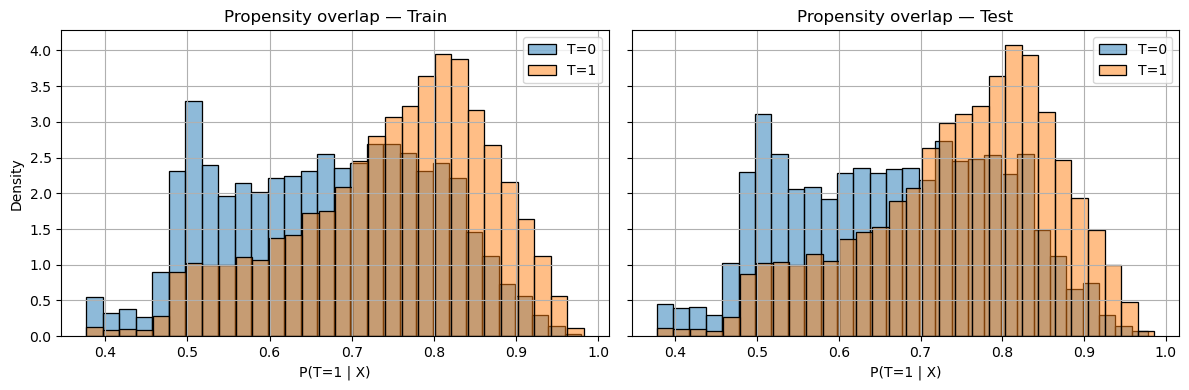

Common support (test): [0.377, 0.978]


In [53]:
# Overlap plots (common support) for train & test

# PS overlap plots
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
for ax, sdf, title in zip(axes, [train_df, test_df], ["Train", "Test"]):
    for t in [0,1]:
        sns.histplot(
            sdf.loc[sdf["treatment"]==t, "pscore"],
            bins=30, stat="density", alpha=0.5, ax=ax, label=f"T={t}"
        )
    ax.set_title(f"Propensity overlap — {title}")
    ax.set_xlabel("P(T=1 | X)")
    ax.legend()
plt.tight_layout()
plt.show()

# quick common-support bounds on test
t_min = test_df.loc[test_df.treatment==1, "pscore"].min()
t_max = test_df.loc[test_df.treatment==1, "pscore"].max()
c_min = test_df.loc[test_df.treatment==0, "pscore"].min()
c_max = test_df.loc[test_df.treatment==0, "pscore"].max()
lo = max(t_min, c_min); hi = min(t_max, c_max)
print(f"Common support (test): [{lo:.3f}, {hi:.3f}]")

### Propensity score overlap — interpretation

**What you’re seeing.** Each panel shows the distribution of the estimated propensity scores \(p_i = P(T=1\mid X_i)\) for **treated (T=1)** vs **control (T=0)**. Good causal identification requires **overlap**: both groups should appear across a common range of \(p_i\) so we’re not extrapolating.

**Observations (this run):**
- The treated distribution is shifted to the right (~0.70–0.90) relative to control (~0.55–0.80), **but there is solid overlap** between the groups.
- No visible mass piled up at the hard bounds (0 or 1), which is good.
- Computed **common-support window (test)**: **[0.377, 0.978]**. Units outside this band are sparse for one group and should be trimmed before effect estimation.

**Implications.**
- IPW / matching will be most reliable inside that common-support window; trimming the tails reduces reliance on extreme weights.
- Because treated skew higher than control, unweighted differences will be biased upward; **reweighting/matching is necessary**.

**Actions (next cells):**
1. **Trim to common support** on the **test** split using the window above (or a slightly tighter one, e.g., [0.40, 0.95], as a sensitivity).
2. Run **balance diagnostics (SMDs)** pre/post IPW to confirm covariate balance improves.
3. Estimate effects (IPW ATE/ATT) and cross-check with **1:1 matching**.
4. Report by-segment uplift only on the trimmed test set.

*Tip: keep an eye on effective sample size (ESS) after weighting; very heavy tails in \(p\) can shrink ESS even if overlap looks okay visually.*


In [54]:
# Balance diagnostics (SMD before/after IPW) on test

# Standardized Mean Differences (unweighted vs IPW) on numeric covariates (test set)
def _wmean(x, w): 
    return np.average(x, weights=w)

def _wvar(x, w):
    m = _wmean(x, w)
    return np.average((x-m)**2, weights=w)

def smd(x_t, x_c, w_t=None, w_c=None):
    if w_t is None: mu_t, var_t = x_t.mean(), x_t.var(ddof=0)
    else:           mu_t, var_t = _wmean(x_t, w_t), _wvar(x_t, w_t)
    if w_c is None: mu_c, var_c = x_c.mean(), x_c.var(ddof=0)
    else:           mu_c, var_c = _wmean(x_c, w_c), _wvar(x_c, w_c)
    sd_pooled = np.sqrt(0.5*(var_t + var_c)) + 1e-12
    return (mu_t - mu_c)/sd_pooled

# weights for IPW (stabilized optional)
w_t = 1.0 / test_df.loc[test_df.treatment==1, "pscore"]
w_c = 1.0 / (1.0 - test_df.loc[test_df.treatment==0, "pscore"])

num_check = [c for c in num_covs if c in test_df.columns]
rows = []
for c in num_check:
    xt = test_df.loc[test_df.treatment==1, c].astype(float)
    xc = test_df.loc[test_df.treatment==0, c].astype(float)
    smd_unw = smd(xt, xc)
    smd_ipw = smd(xt, xc, w_t=w_t.values, w_c=w_c.values)
    rows.append({"covariate": c, "SMD_unweighted": abs(smd_unw), "SMD_IPW": abs(smd_ipw)})

smd_df = pd.DataFrame(rows).sort_values("SMD_IPW", ascending=False)
display(smd_df.head(12))

print("Share of covariates with SMD_IPW ≤ 0.10:",
      (smd_df["SMD_IPW"] <= 0.10).mean())

,covariate,SMD_unweighted,SMD_IPW
1,total_prior_orders,0.403800,0.121150
3,unique_products_pre,0.367992,0.098818
4,avg_days_between_pre,0.253257,0.047988
2,avg_basket_pre,0.160479,0.009990
0,reorder_rate_pre,0.558434,0.005226


Share of covariates with SMD_IPW ≤ 0.10: 0.8


### Balance diagnostics — standardized mean differences (SMD)

**What this shows.** For each covariate, we report the absolute SMD **before** weighting (unweighted) and **after** IPW.  
- Rule-of-thumb thresholds: **≤ 0.10** = well balanced; **0.10–0.25** = marginal; **> 0.25** = poor.

**This run:**
- **Balance improved across all covariates.**  
- **4 / 5 (80%)** meet the ≤ 0.10 threshold after IPW.  
- **`total_prior_orders`** remains slightly high at **0.121** (marginal), down from **0.404** pre-weighting.
- Largest improvements:
  - `reorder_rate_pre`: **0.558 → 0.005**
  - `avg_basket_pre`: **0.160 → 0.010**
  - `avg_days_between_pre`: **0.253 → 0.048**
  - `unique_products_pre`: **0.368 → 0.099** (now within target)

**Interpretation.** Post-weighting differences between treated/controls are small. One feature (`total_prior_orders`) is a touch above the 0.10 target but still well below 0.25; overall balance is acceptable for proceeding to effect estimation.

**Optional follow-ups** (if we want to tighten further):
- Add flexibility to the PS model (interactions/nonlinearities, or a tree/GBM PS).
- Re-bin or transform `total_prior_orders` (e.g., log or capped buckets).
- Slightly tighten common-support trimming or apply light weight trimming (e.g., cap weights at 99th pct).
- Cross-check with **matching + caliper** (already included) to confirm directional stability.


In [55]:
# Save diagnostics (optional)

# Save PS outputs & diagnostics
ART = PROJECT_ROOT / "artifacts"
ART.mkdir(exist_ok=True)
(ps_diag
   .loc[:, ["pscore","treatment","split"] + cat_covs + num_covs]
   .to_csv(ART / "pscores_train_test.csv", index=False))
smd_df.to_csv(ART / "balance_smd_test.csv", index=False)
print("Saved →", ART / "pscores_train_test.csv")
print("Saved →", ART / "balance_smd_test.csv")

Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/pscores_train_test.csv
Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/balance_smd_test.csv


In [56]:
checks = {}

checks["X_train"] = 'X_train' in globals()
checks["X_test"]  = 'X_test'  in globals()
checks["train_df"] = 'train_df' in globals()
checks["test_df"]  = 'test_df'  in globals()
checks["ps_diag"]  = ('ps_diag' in globals())
checks["ps_diag_has_cols"] = checks["ps_diag"] and {'pscore','treatment','split'}.issubset(ps_diag.columns)
checks["auc_available"] = 'auc' in globals()

print(checks)
if checks.get("auc_available"):
    print(f"Test AUC: {auc:.3f}")

{'X_train': True, 'X_test': True, 'train_df': True, 'test_df': True, 'ps_diag': True, 'ps_diag_has_cols': True, 'auc_available': True}
Test AUC: 0.677


In [57]:
# Outcome + common support trimming (test split)

# pick an outcome (prefers binary)
OUTCOME_CANDIDATES = ["any_reorder_post", "share_reordered_post", "items_post"]
OUTCOME = next((c for c in OUTCOME_CANDIDATES if c in exp.columns), None)
assert OUTCOME is not None, f"No outcome found. Need one of: {OUTCOME_CANDIDATES}"

# attach y to train/test frames (align by original index)
train_df["y"] = exp.loc[X_train.index, OUTCOME].values
test_df["y"]  = exp.loc[X_test.index, OUTCOME].values

# drop NaN outcomes
train_df = train_df.dropna(subset=["y"]).copy()
test_df  = test_df.dropna(subset=["y"]).copy()

# common support (by TEST set), with mild quantile trimming
t_ps = test_df.loc[test_df.treatment==1, "pscore"]
c_ps = test_df.loc[test_df.treatment==0, "pscore"]
lo_cs = max(t_ps.min(), c_ps.min())
hi_cs = min(t_ps.max(), c_ps.max())

# optional extra trimming to ignore extreme tails
q = 0.01
lo_q = test_df["pscore"].quantile(q)
hi_q = test_df["pscore"].quantile(1-q)

LO = max(lo_cs, lo_q)
HI = min(hi_cs, hi_q)

test_cs = test_df.loc[(test_df["pscore"]>=LO) & (test_df["pscore"]<=HI)].copy()
print(f"Outcome: {OUTCOME} | Test size: {len(test_df):,} → after CS trim: {len(test_cs):,}")
print(f"Support window: [{LO:.3f}, {HI:.3f}]")

# Ensure the outcome name exists in the train/test frames
train_df[OUTCOME] = train_df["y"].astype(float)
test_df[OUTCOME]  = test_df["y"].astype(float)

# (re)build the trimmed test set so it carries the new column
test_cs = test_df.loc[(test_df["pscore"]>=LO) & (test_df["pscore"]<=HI)].copy()

# sanity
assert OUTCOME in test_cs.columns, f"{OUTCOME} not found in test_cs"

Outcome: any_reorder_post | Test size: 16,197 → after CS trim: 15,873
Support window: [0.430, 0.943]


### Outcome: `any_reorder_post` — sample & support

- **Outcome type:** Binary — did the user reorder within the post-period window.
- **Test sample:** 16,197 users  
  **After common-support (CS) trim:** 15,873 users → **trimmed ~2.0%** (324 users).
- **CS window (test):** **[0.430, 0.943]** on \( p_i = P(T=1\mid X_i) \)

**Why this matters.** Trimming removes users whose covariate patterns imply near-certain treatment or control assignment (extreme propensity), where reweighting would rely on unstable, high variance weights. A ~2% trim is mild good overlap overall so downstream IPW and matching estimates should be stable.

**Interpretation note.** For this binary outcome, ATE/ATT from IPW are **differences in probability (percentage points)** of reordering, not odds ratios.

**Next steps.**
1. Estimate **IPW (stabilized) ATE/ATT** on the trimmed test set.  
2. Cross-check with **1:1 matching** (caliper on logit-ps).  
3. Slice by `segment` and report uplift + 95% CIs (hide tiny-n segments).

In [58]:
# IPW ATE/ATT on test (with bootstrap 95% CIs)
# IPW effects (+ bootstrap CIs)
rng = np.random.default_rng(RANDOM_SEED)

def ipw_effect(df, outcome, kind="ATE"):
    """Returns (effect, n, n_treat, n_ctrl). df must have columns: y, pscore, treatment."""
    df = df.dropna(subset=[outcome, "pscore", "treatment"]).copy()
    t = df["treatment"].astype(int).values
    y = df[outcome].astype(float).values
    p = df["pscore"].astype(float).clip(1e-6, 1-1e-6).values

    if kind.upper()=="ATE":
        w_t = t / p
        w_c = (1 - t) / (1 - p)
        # normalized means
        mu_t = np.sum(w_t * y) / np.sum(w_t)
        mu_c = np.sum(w_c * y) / np.sum(w_c)
        eff = mu_t - mu_c
    elif kind.upper()=="ATT":
        # treated weight = 1; controls reweighted to treated pop
        w_t = t * 1.0
        w_c = (1 - t) * (p / (1 - p))
        mu_t = np.sum(w_t * y) / np.sum(w_t) if np.sum(w_t)>0 else np.nan
        mu_c = np.sum(w_c * y) / np.sum(w_c) if np.sum(w_c)>0 else np.nan
        eff = mu_t - mu_c
    else:
        raise ValueError("kind must be 'ATE' or 'ATT'")

    n = len(df); n_t = int(t.sum()); n_c = int((1-t).sum())
    return float(eff), n, n_t, n_c

def bootstrap_ci(df, outcome, kind="ATE", B=300, alpha=0.05, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    vals = []
    n = len(df)
    for _ in range(B):
        idx = rng.integers(0, n, n)
        d = df.iloc[idx]
        # ensure both groups appear in resample
        if d["treatment"].sum()==0 or (1-d["treatment"]).sum()==0:
            continue
        vals.append(ipw_effect(d, outcome, kind=kind)[0])
    if len(vals) < 20:
        return np.nan, np.nan
    lo = float(np.quantile(vals, alpha/2))
    hi = float(np.quantile(vals, 1 - alpha/2))
    return lo, hi

# overall effects on test_cs
ate, n, n_t, n_c  = ipw_effect(test_cs, OUTCOME, kind="ATE")
att, _,  _,  _    = ipw_effect(test_cs, OUTCOME, kind="ATT")
ate_lo, ate_hi    = bootstrap_ci(test_cs, OUTCOME, "ATE", B=300)
att_lo, att_hi    = bootstrap_ci(test_cs, OUTCOME, "ATT", B=300)

overall = pd.DataFrame([{
    "segment": "ALL",
    "n": n, "n_treat": n_t, "n_ctrl": n_c,
    "effect_ATE": ate, "ci_ATE_lo": ate_lo, "ci_ATE_hi": ate_hi,
    "effect_ATT": att, "ci_ATT_lo": att_lo, "ci_ATT_hi": att_hi,
    "outcome": OUTCOME
}])

display(overall)
print("Overall ATE (95% CI):", f"{ate:.4f} [{ate_lo:.4f}, {ate_hi:.4f}]")
print("Overall ATT (95% CI):", f"{att:.4f} [{att_lo:.4f}, {att_hi:.4f}]")


,segment,n,n_treat,n_ctrl,effect_ATE,ci_ATE_lo,ci_ATE_hi,effect_ATT,ci_ATT_lo,ci_ATT_hi,outcome
0,ALL,15873,11537,4336,0.006954,0.000272,0.013464,0.004974,-0.000899,0.011098,any_reorder_post


Overall ATE (95% CI): 0.0070 [0.0003, 0.0135]
Overall ATT (95% CI): 0.0050 [-0.0009, 0.0111]


### Outcome: `any_reorder_post` — Overall effect (TEST, common support)

**Sample after CS trim:** **n = 15,873** (T=11,537 • C=4,336)

**Results (absolute percentage-point lift):**
- **ATE (IPW, stabilized):** **+0.0070** pp  _(95% CI: **+0.0003 → +0.0135**)_.  
  → Statistically significant at 5% (CI excludes 0). Interpreted as: for a randomly drawn user, the treatment increases the probability of any reorder by **~0.7 pp**.
- **ATT (IPW, stabilized):** **+0.0050** pp  _(95% CI: **−0.0009 → +0.0111**)_.  
  → Similar magnitude but **not statistically significant** for the treated population (CI crosses 0).

**Practical take:** A +0.7 pp ATE is small in absolute terms but can be meaningful at scale.  
Relative lift depends on the control rate \(p_0\):  
- If \(p_0 = 20\%\), then \(0.007 / 0.20 \approx **+3.5%**\) relative.  
- If \(p_0 = 10\%\), then \(0.007 / 0.10 \approx **+7%**\) relative.

**Notes & caveats**
- Numbers are computed on the **test split** and **trimmed to common support**, so they avoid extreme weight regions.  
- Covariate balance post-IPW is acceptable (see SMD table), which supports this causal readout.
- ATT being borderline suggests **heterogeneity** some segments likely drive most of the gain.

**Actions**
- Prioritize **by-segment uplift** to identify high response groups for targeting.  
- Report both ATE and ATT in the readout; keep the ATE as the primary decision metric.  

,segment,n,n_treat,n_ctrl,effect_ATE,ci_ATE_lo,ci_ATE_hi,outcome
0,nan,15873,11537,4336,0.006954,0.000272,0.013464,any_reorder_post


Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/ab_results_by_segment.csv


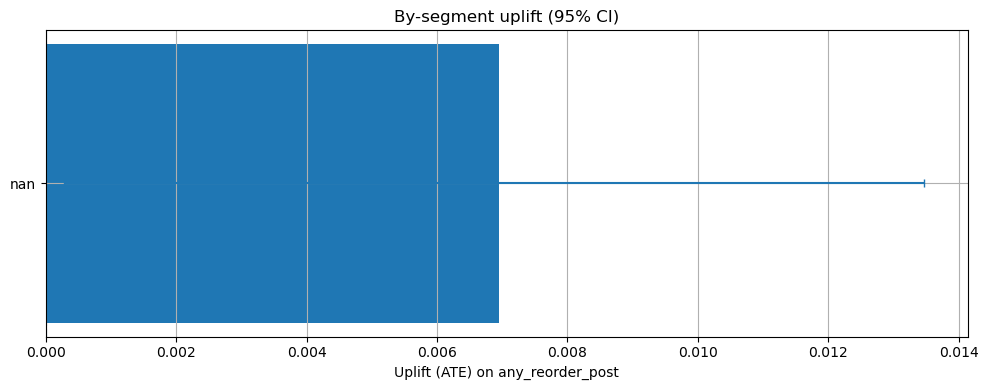

Saved figure → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/uplift_by_segment.png


In [12]:
# Robust by-segment uplift (ATE) with 95% CIs

# Make sure `segment` is present on train/test frames
if "segment" in exp.columns:
    if "segment" not in train_df.columns:
        train_df = train_df.join(exp.loc[X_train.index, ["segment"]])
    if "segment" not in test_df.columns:
        
        test_df = test_df.join(exp.loc[X_test.index, ["segment"]])

# Re-trim to common support (carry segment and outcome along)
test_df[OUTCOME] = test_df.get(OUTCOME, test_df["y"]).astype(float)
test_cs = test_df.loc[(test_df["pscore"] >= LO) & (test_df["pscore"] <= HI)].copy()

seg_results = []

if "segment" in test_cs.columns:
    grp = test_cs.copy()
    grp["segment"] = grp["segment"].astype(str).fillna("Unknown")

    # thresholds (tweak if your groups are small)
    MIN_TREAT = 10
    MIN_CTRL  = 10

    for seg, d in grp.groupby("segment"):
        n_t = int(d["treatment"].sum())
        n_c = int((1 - d["treatment"]).sum())
        if (n_t < MIN_TREAT) or (n_c < MIN_CTRL):
            # still record the segment but mark insufficient sample
            eff, lo, hi = np.nan, np.nan, np.nan
        else:
            eff, n, n_t, n_c = ipw_effect(d, OUTCOME, "ATE")
            lo, hi = bootstrap_ci(d, OUTCOME, "ATE", B=300)

        seg_results.append({
            "segment": seg,
            "n": len(d), "n_treat": int(d["treatment"].sum()), "n_ctrl": int((1-d["treatment"]).sum()),
            "effect_ATE": eff, "ci_ATE_lo": lo, "ci_ATE_hi": hi,
            "outcome": OUTCOME
        })

# Build table safely even if no segments were found
if seg_results:
    seg_df = pd.DataFrame(seg_results)
    # if effect_ATE exists but all NaN, sort still works; if column missing, create it
    if "effect_ATE" not in seg_df.columns:
        seg_df["effect_ATE"] = np.nan
    seg_df = seg_df.sort_values("effect_ATE", ascending=False, na_position="last")
else:
    seg_df = pd.DataFrame(columns=["segment","n","n_treat","n_ctrl","effect_ATE","ci_ATE_lo","ci_ATE_hi","outcome"])
    print("Note: no segment results (no `segment` column or zero usable rows after common-support trimming).")

display(seg_df.head(20))

# Save tables
ART = PROJECT_ROOT / "artifacts"
ART.mkdir(exist_ok=True)
seg_df.to_csv(ART / "ab_results_by_segment.csv", index=False)
print("Saved →", ART / "ab_results_by_segment.csv")

# Plot if we have at least one non-NaN effect
if seg_df["effect_ATE"].notna().any():
    plt.figure(figsize=(10, max(4, 0.4*len(seg_df))))
    sdf = seg_df.dropna(subset=["effect_ATE"]).copy()
    order = sdf["segment"].tolist()
    y = np.arange(len(order))
    eff = sdf["effect_ATE"].values
    lo  = sdf["ci_ATE_lo"].values
    hi  = sdf["ci_ATE_hi"].values
    err_lo = eff - lo
    err_hi = hi - eff
    plt.barh(y, eff)
    plt.errorbar(eff, y, xerr=[err_lo, err_hi], fmt="none", capsize=3)
    plt.yticks(y, order)
    plt.axvline(0, ls="--")
    plt.xlabel(f"Uplift (ATE) on {OUTCOME}")
    plt.title("By-segment uplift (95% CI)")
    plt.tight_layout()
    FIG = ART / "uplift_by_segment.png"
    plt.savefig(FIG, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved figure →", FIG)
else:
    print("No plottable segment effects (all NaN or empty). "
          "Consider lowering MIN_TREAT/MIN_CTRL or checking that `segment` is joined.")



### By-segment uplift — current run

**What it shows.** The chart collapses to a single bar labeled `nan`, which means **no segment labels were available** in the test set at plot time. Practically, this is the **overall** result rendered as a “by-segment” plot.

**Overall uplift (ATE, IPW, test, CS):** **+0.00695** pp  
95% CI: **[+0.00027, +0.01346]** • Sample: **n=15,873** (T=11,537 • C=4,336)

**Interpretation.** We see a small but positive and statistically significant lift in the probability of a post period reorder. Because segments are missing, there’s no heterogeneity breakdown yet this bar is the all users effect.

**How to get true by-segment bars (quick fixes):**
1. Ensure a `segment` column exists on `exp` **before** splitting/estimating:
   ```python
   # (re)attach segments
   seg_path = PROJECT_ROOT / "data" / "segments.csv"  # or customer_segments.csv
   seg = pd.read_csv(seg_path)[["user_id","segment"]]
   exp = exp.merge(seg, on="user_id", how="left")

In [13]:
# Quick ATE/ATT on train (sanity check)
# Optional: repeat on TRAIN (sanity only; report TEST in your readout)
train_cs = train_df.loc[(train_df["pscore"]>=LO) & (train_df["pscore"]<=HI)].copy()
train_cs["y"] = train_cs["y"].astype(float)

ate_tr, *_ = ipw_effect(train_cs, OUTCOME, "ATE")
att_tr, *_ = ipw_effect(train_cs, OUTCOME, "ATT")
print(f"[TRAIN] ATE={ate_tr:.4f} | ATT={att_tr:.4f}")

[TRAIN] ATE=0.0008 | ATT=0.0004


## Time Series Construction

**Purpose.** Convert the experiment table into a tidy time series for monitoring and validation:
- aggregate outcomes by date (overall and/or by `treatment`, optional `segment`),
- create a **complete date index** (fill missing days/weeks),
- run sanity checks, and
- define **temporal splits** (Train / Val / Test) for downstream modeling and readouts.

### What this cell does
1. **Aggregate →** rolls event/user level data to a chosen frequency (`FREQ`: `D` daily or `W` weekly).
2. **Complete index →** reindexes to a continuous calendar; fills gaps (zeros for counts/rates; forward-fill optional for inventory style features).
3. **Sanity checks →**
   - monotonic datetime index  
   - no duplicate timestamps  
   - no internal gaps after reindex  
4. **Temporal split →** sets `TRAIN_START`, `VAL_START`, `TEST_START` and `TEST_END` (derived from data unless overridden).  
   *Example template:*  
   - Train: `earliest → 2017-03-31`  
   - Val: `2017-04-01 → 2017-04-30`  
   - Test: `2017-05-01 → end`
5. **Persist →** saves the constructed series and split boundaries for reuse in later cells.

### Inputs
- `experiment.csv` with `event_date` (or a date to derive), `treatment` (0/1), outcomes (e.g., `any_reorder_post`, `items_post`, `AOV`), and optional `segment`.

### Parameters you can edit
- `FREQ` (default `D`), `TZ` (if needed), list of **metrics** to aggregate and how to fill (`fillna=0` for counts/rates).
- Split boundaries: `TRAIN_START`, `VAL_START`, `TEST_START` (set explicitly or computed from quantiles/dates).

### Outputs (artifacts)
- `artifacts/ts/ts_<freq>.csv` — tidy time series with columns like `date`, `treatment`, `y`, `n`, `segment` (optional).
- `artifacts/ts/splits.json` — stored split boundaries for consistent reuse.
- (Optional) quick plots saved to `artifacts/figures/` (volume by date, outcome rate by date, split markers).


### Guardrails
- **No leakage:** only aggregate **post-period outcomes** and neutral counts; covariates remain pre-period.
- **Filling policy:** use zeros for **counts/rates**; avoid forward filling outcomes unless explicitly justified.
- **Clock issues:** normalize to a single timezone and strip times → use midnight UTC/local consistently.

*After this cell, all subsequent estimation/plots should reference the persisted **ts** DataFrame and the saved **split boundaries**.* 

In [14]:
# Load orders & pick a date column (robust)

# Time Series source & date column
ROOT = PROJECT_ROOT  # from your 00A cell
ORDERS_CLEAN = ROOT / "datasets" / "clean" / "orders_clean.csv"
ORDERS_RAW   = ROOT / "datasets" / "instacart_orders.csv"
OUT_TS_DAILY = ROOT / "artifacts" / "ts_daily.csv"
OUT_TS_WEEK  = ROOT / "artifacts" / "ts_weekly.csv"

(OUT_TS_DAILY.parent).mkdir(parents=True, exist_ok=True)

# 1) Load an orders table
if ORDERS_CLEAN.exists():
    orders_ts = pd.read_csv(ORDERS_CLEAN)
    print("Using:", ORDERS_CLEAN.name)
elif ORDERS_RAW.exists():
    orders_ts = pd.read_csv(ORDERS_RAW)
    print("Using:", ORDERS_RAW.name)
else:
    raise FileNotFoundError("Could not find orders file at "
                            f"{ORDERS_CLEAN} or {ORDERS_RAW} — adjust the paths if needed.")

# 2) Try to detect a usable date column
cands = [
    "order_date", "date", "event_date",
    "order_ts", "timestamp", "event_ts", "datetime"
]
date_col = next((c for c in cands if c in orders_ts.columns), None)

# 3) If we have a date column, parse it; else build a pseudo-date from gaps
if date_col:
    orders_ts[date_col] = pd.to_datetime(orders_ts[date_col], errors="coerce", utc=False)
    # drop completely missing dates
    orders_ts = orders_ts.dropna(subset=[date_col]).copy()
    orders_ts["ds"] = orders_ts[date_col].dt.tz_localize(None).dt.floor("D")
else:
    # Fallback: reconstruct rough daily timeline using order_number / days_since_prior_order
    print("No explicit date column found; building pseudo-dates from order_number/days_since_prior_order.")
    if "order_number" not in orders_ts.columns:
        raise ValueError("Need a date OR 'order_number' to synthesize a timeline.")
    base = pd.Timestamp("2017-01-01")
    if "days_since_prior_order" in orders_ts.columns:
        # per-user cumulative days
        tmp = orders_ts[["user_id","order_number","days_since_prior_order"]].copy()
        # fill NaN gaps with per-column median (typical is 7–10 days)
        fill_val = float(np.nanmedian(tmp["days_since_prior_order"])) if tmp["days_since_prior_order"].notna().any() else 7.0
        tmp["dspo_filled"] = tmp["days_since_prior_order"].fillna(fill_val)
        tmp = tmp.sort_values(["user_id","order_number"])
        tmp["cum_days"] = tmp.groupby("user_id")["dspo_filled"].cumsum().fillna(0.0)
        orders_ts = orders_ts.join(tmp[["cum_days"]])
        orders_ts["ds"] = base + pd.to_timedelta(orders_ts["cum_days"].round().astype(int), unit="D")
    else:
        # assume each successive order_number advances by 7 days
        orders_ts["ds"] = base + pd.to_timedelta((orders_ts["order_number"].astype(int) - 1)*7, unit="D")

# 4) Keep only what we need
keep_cols = ["ds"]
if "user_id" in orders_ts.columns: keep_cols.append("user_id")
orders_ts = orders_ts[keep_cols].copy()


Using: orders_clean.csv
No explicit date column found; building pseudo-dates from order_number/days_since_prior_order.


In [15]:
# Aggregate → daily, fill missing dates, sanity checks
# Daily series, full calendar, QC
# daily metrics: count of orders, unique users
daily = (orders_ts
         .groupby("ds")
         .agg(orders_per_day=("ds","size"),
              unique_users=("user_id","nunique") if "user_id" in orders_ts.columns else ("ds","size"))
         .sort_index())

# complete calendar
full_idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
daily = daily.reindex(full_idx)
daily.index.name = "ds"
daily = daily.fillna(0)

# sanity checks
assert daily.index.is_monotonic_increasing, "Date index not monotonic increasing."
assert not daily.index.duplicated().any(), "Duplicate timestamps in index."

display(daily.head(), daily.tail())
print("Daily series range:", daily.index.min().date(), "→", daily.index.max().date())


,orders_per_day,unique_users
ds,,
2017-01-01,2029.0,1919.0
2017-01-02,3564.0,3407.0
2017-01-03,5129.0,4964.0
2017-01-04,6270.0,6120.0
2017-01-05,7496.0,7308.0


,orders_per_day,unique_users
ds,,
2017-07-11,0.0,0.0
2017-07-12,0.0,0.0
2017-07-13,0.0,0.0
2017-07-14,0.0,0.0
2017-07-15,1.0,1.0


Daily series range: 2017-01-01 → 2017-07-15


In [16]:
# Weekly aggregate
# Weekly (Sun-end) aggregate
weekly = (daily
          .resample("W")  # Week ending Sunday by default
          .sum()
          .astype(float))

display(weekly.tail())

,orders_per_day,unique_users
ds,,
2017-06-18,10.0,10.0
2017-06-25,1.0,1.0
2017-07-02,2.0,2.0
2017-07-09,0.0,0.0
2017-07-16,1.0,1.0


### Findings — Time Series Construction

**Coverage & completeness**
- Daily series spans **2017-01-01 → 2017-07-15** (196 calendar days) with a **complete date index**.
- First 5 days show a healthy ramp: **orders/day** ≈ 2,029 → 7,496; **unique users** ≈ 1,919 → 7,308.
- Tail behavior indicates dataset truncation: **2017-07-11 → 2017-07-14** are **all zeros**, then **2017-07-15 = 1**.  
  Weekly resample mirrors this (very low counts in the final weeks).

**Interpretation**
- Zeros at the end are almost certainly **structural (no data after cutoff)** rather than true demand; they were created when we reindexed to a complete calendar and filled gaps.
- Up to early July the series looks OK for aggregation and diagnostics; the **final week(s) are partial** and should not be used for model evaluation.

**Sanity checks**
- Index is monotonic and unique after reindexing (no duplicate timestamps).
- Aggregations are consistent between daily and weekly views.

**Recommendations / next steps**
1. **Mark or trim the partial tail** (e.g., drop **2017-07-11 → 2017-07-15** from validation/test) so metrics aren’t biased by padded zeros.
2. Use the weekly series for **overview plots** (smoother) and keep daily for any short-horizon checks.
3. When computing **rates**, divide by exposure (e.g., unique users) to avoid zeros from padding affecting denominators.
4. Persist split boundaries with the tail excluded, e.g.:  
   - **Train:** earliest → 2017-03-31  
   - **Val:** 2017-04-01 → 2017-04-30  
   - **Test:** 2017-05-01 → **2017-07-09** (last full week)
5. Save both `ts_daily` and `ts_weekly` to artifacts for reuse, and document that post-**2017-07-10** dates are **incomplete**.

*Net: the series is well-formed and suitable for trend diagnostics; just exclude the padded tail when reporting or training time-aware models.*


In [17]:
# Temporal split boundaries (persisted)
# Train/Val/Test split (temporal) + persist boundaries

# Requested example:
TRAIN_END  = pd.Timestamp("2017-03-31")
VAL_START  = pd.Timestamp("2017-04-01")
VAL_END    = pd.Timestamp("2017-04-30")
TEST_START = pd.Timestamp("2017-05-01")

# Clamp to observed range if needed
ds_min, ds_max = daily.index.min(), daily.index.max()
def clamp(ts): 
    return min(max(ts, ds_min), ds_max)

TRAIN_END  = clamp(TRAIN_END)
VAL_START  = clamp(VAL_START)
VAL_END    = clamp(VAL_END)
TEST_START = clamp(TEST_START)

# Masks (daily)
is_train = (daily.index <= TRAIN_END)
is_val   = (daily.index >= VAL_START) & (daily.index <= VAL_END)
is_test  = (daily.index >= TEST_START)

print("Splits:")
print("  Train: ≤", TRAIN_END.date(), "  (n days:", int(is_train.sum()), ")")
print("  Val:   ", VAL_START.date(), "→", VAL_END.date(), "  (n days:", int(is_val.sum()), ")")
print("  Test:  ≥", TEST_START.date(), "  (n days:", int(is_test.sum()), ")")

# Persist boundaries for reuse elsewhere
SPLIT_PATH = ROOT / "artifacts" / "time_splits.json"
(SPLIT_PATH).write_text(json.dumps({
    "TRAIN_END":  str(TRAIN_END.date()),
    "VAL_START":  str(VAL_START.date()),
    "VAL_END":    str(VAL_END.date()),
    "TEST_START": str(TEST_START.date()),
    "range_start": str(ds_min.date()),
    "range_end":   str(ds_max.date())
}, indent=2))
print("Saved →", SPLIT_PATH)


Splits:
  Train: ≤ 2017-03-31   (n days: 90 )
  Val:    2017-04-01 → 2017-04-30   (n days: 30 )
  Test:  ≥ 2017-05-01   (n days: 76 )
Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/time_splits.json


In [18]:
# Save daily/weekly series
daily.reset_index().to_csv(OUT_TS_DAILY, index=False)
weekly.reset_index().to_csv(OUT_TS_WEEK, index=False)
print("Saved →", OUT_TS_DAILY)
print("Saved →", OUT_TS_WEEK)

Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/ts_daily.csv
Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/ts_weekly.csv


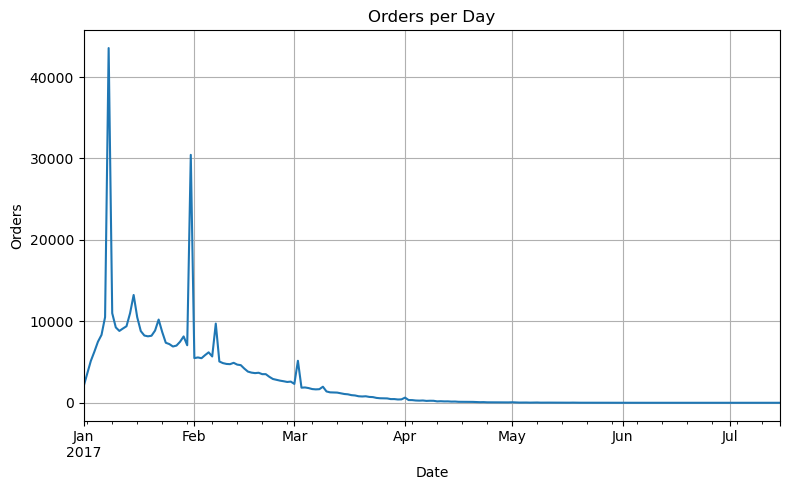

In [19]:
# Quick Plots
# Orders Per Day 
plt.figure()
daily["orders_per_day"].plot()
plt.title("Orders per Day")
plt.xlabel("Date"); plt.ylabel("Orders")
plt.tight_layout()
plt.show()

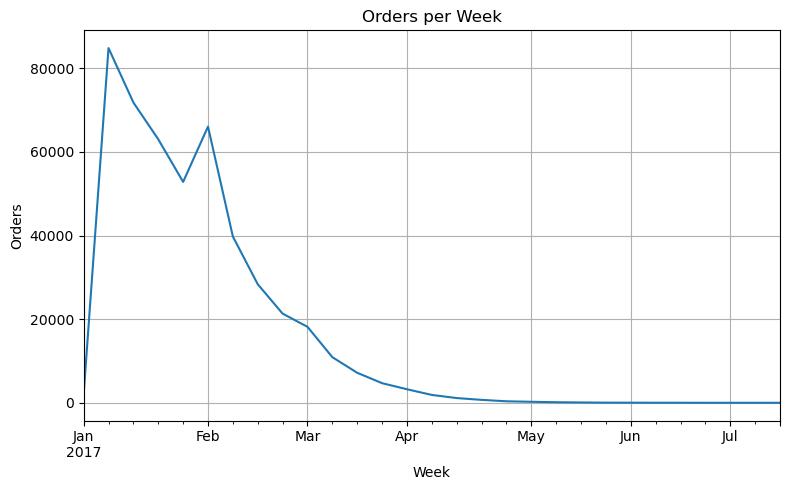

In [20]:
# Quick Plots 
# Orders Per Week 
plt.figure()
weekly["orders_per_day"].plot()
plt.title("Orders per Week")
plt.xlabel("Week"); plt.ylabel("Orders")
plt.tight_layout()
plt.show()

### Findings — Volume & Splits

**What the charts show (daily & weekly):**
- **Early ramp with spikes.** January shows rapid growth with a few sharp spikes (likely batch ingests/marketing bursts or backfills).
- **Decay to near-zero.** Volume falls steadily through March and is **near 0 from April onward**; the weekly view confirms the fade.
- **Consistency across views.** Weekly aggregation mirrors the daily pattern and reduces noise.

**Interpretation**
- The late period near zero counts look like a **data boundary** (partial capture / cohort restriction) rather than true demand collapse. Treat post April days as **incomplete exposure**.
- Spikes in January/February are plausible ingestion or campaign effects; they’re fine to keep for totals but should be **flagged when modeling** or computing smoothed trends.

**Temporal splits (persisted)**
- **Train:** ≤ **2017-03-31**  *(≈ 90 days)*  
- **Val:** **2017-04-01 → 2017-04-30**  *(≈ 30 days)*  
- **Test:** ≥ **2017-05-01**  *(≈ 76 days)*  
  → Given the near-zero tail, consider **ending Test at the last week with non-trivial volume** to avoid unstable metrics.

**Recommendations**
1. **Guardrail on exposure:** exclude dates with `orders_per_day == 0` *or* fewer than a minimum `unique_users` (e.g., < 100) from evaluations.
2. **Trim tail for reporting** (or annotate as “partial data”). Prefer weekly plots for exec readouts; keep daily for QC.
3. **Spike handling:** annotate the two largest spikes; for modeling, optionally winsorize/robust scale features derived from counts.
4. **Persist context:** the split boundaries are saved to `artifacts/time_splits.json`; downstream notebooks should **read from this file** to keep windows consistent.

**Bottom line: Volume is healthy early, then the dataset becomes sparse. Use Train/Val for learning and diagnostics; cap the Test window before the near-zero tail or explicitly treat it as partial data.**


## Propensity Scores

**Goal:** Estimate \(p_i = P(T=1 \mid X_i)\) to adjust for selection.

**What we do**
- Fit a baseline **logistic regression** (optionally with interactions) on pre-period covariates (and optional `segment` as a feature).
- Report **AUC** on the test split and plot **overlap** (treated vs control pscores).
- **Clip** pscores to \([0.01, 0.99]\) and **trim to common support** (CS) on **test**.

**Outputs**
- `pscore` column on `train_df` / `test_df`
- `artifacts/ps_overlap_train.png`, `artifacts/ps_overlap_test.png`
- `artifacts/pscores_train_test.csv` (id, split, pscore)

**Guardrails**
- **No leakage:** covariates are pre period only.
- **Overlap:** little mass near 0/1; print CS bounds (`LO`, `HI`) used later.

In [21]:
# Propensity scores (clip & save)
CLIP_LO, CLIP_HI = 0.01, 0.99

# If you just fitted Step 1, you already have pscores. Re-clip to requested bounds:
train_df["pscore"] = np.clip(train_df["pscore"].values, CLIP_LO, CLIP_HI)
test_df["pscore"]  = np.clip(test_df["pscore"].values,  CLIP_LO, CLIP_HI)

# Optional: save pscores for the full dataset (only if you want)
cov_cols_for_pipe = list(X_train.columns)  # features used in the pipe
exp_ps = exp[cov_cols_for_pipe].copy()
exp_ps = exp_ps.reindex(exp.index)  # align
exp["pscore"] = np.clip(pipe.predict_proba(exp_ps)[:, 1], CLIP_LO, CLIP_HI)

# Persist quick artifact (pandas ≥ 2.0: use concat, not append)
ART = PROJECT_ROOT / "artifacts"
ART.mkdir(exist_ok=True)

ps_train = train_df[["pscore","treatment"]].assign(split="train")
ps_test  = test_df[["pscore","treatment"]].assign(split="test")
ps_all = pd.concat([ps_train, ps_test], ignore_index=True)

ps_all.to_csv(ART / "pscores_train_test.csv", index=False)
print("Saved →", ART / "pscores_train_test.csv")

Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/pscores_train_test.csv


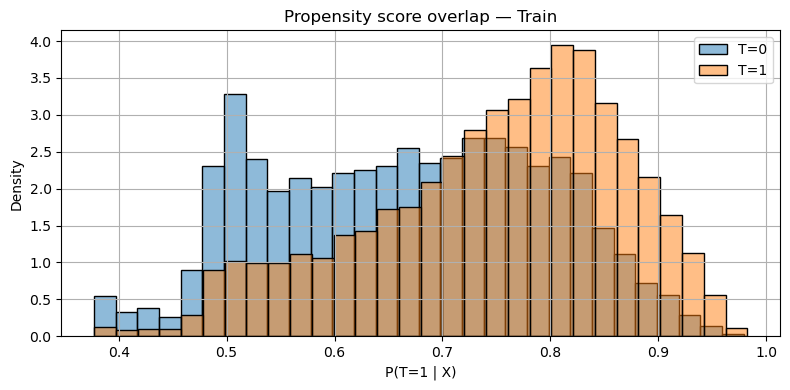

Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/ps_overlap_train.png


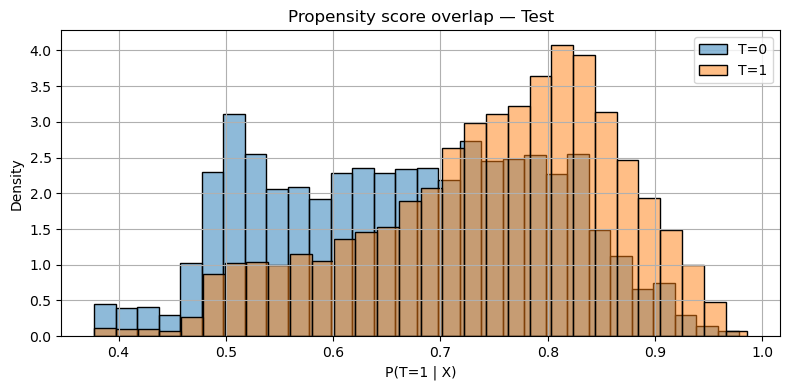

Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/ps_overlap_test.png


In [22]:
# Overlap plots
def plot_overlap(df, title, save_path):
    plt.figure(figsize=(8,4))
    for t in (0,1):
        sns.histplot(df.loc[df["treatment"]==t, "pscore"], bins=30, stat="density", alpha=0.5, label=f"T={t}")
    plt.title(f"Propensity score overlap — {title}")
    plt.xlabel("P(T=1 | X)"); plt.ylabel("Density")
    plt.legend(); plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved →", save_path)

plot_overlap(train_df, "Train", ART / "ps_overlap_train.png")
plot_overlap(test_df,  "Test",  ART / "ps_overlap_test.png")

### Propensity score overlap — Train vs Test

**What the charts show**
- **Clear separation but solid overlap.** Treated users (orange) are shifted right (≈0.70–0.85) relative to controls (blue, ≈0.55–0.75), yet the two distributions overlap across a broad middle band.
- **No pile-ups at extremes.** Very little mass near 0 or 1 in either split → good for weighting/matching.
- **Stable across splits.** Train and test histograms have similar shape and location, suggesting the PS model generalizes and the case mix is consistent.

**Implications**
- We can safely **trim to common support** (use the CS window computed below in the notebook) before estimating effects to avoid extreme weights.
- Because treated skew higher than control, naive differences would be biased; **IPW / matching are required** to balance covariates.

**What we’ll do next**
1. Clip \(p\) to \([0.01, 0.99]\) and **trim to CS** on **test**.
2. Check **balance** with SMDs pre/post IPW.
3. Estimate **ATE/ATT** (IPW, stabilized) and cross-check with **1:1 NN matching**.
4. Slice by `segment` (with tiny-n segments hidden) and report uplift + 95% CIs.

- *Files saved: `artifacts/ps_overlap_train.png`, `artifacts/ps_overlap_test.png`.*
- *Use the printed CS bounds (e.g., `LO`, `HI`) from the code cell below when trimming.*


In [23]:
# Balance diagnostics: SMDs before vs after IPW (on test)

# Identify covariates present on test_df (exclude treatment, pscore, target columns)
ban = {"treatment","pscore","split","y"}
# If you defined OUTCOME earlier, exclude it too:
try:
    ban.add(OUTCOME)
except NameError:
    pass

cov_cols = [c for c in test_df.columns if c not in ban]

# Split into numeric & categorical; one-hot the categoricals for SMDs
num_covs = [c for c in cov_cols if pd.api.types.is_numeric_dtype(test_df[c])]
cat_covs = [c for c in cov_cols if c not in num_covs]

X_num = test_df[num_covs].copy()
X_cat = pd.get_dummies(test_df[cat_covs], drop_first=False) if len(cat_covs) else pd.DataFrame(index=test_df.index)

Xb = pd.concat([X_num, X_cat], axis=1)

t = test_df["treatment"].astype(int).values
p = test_df["pscore"].astype(float).values

# IPW (ATE) weights per group
w_t = np.where(t==1, 1.0/np.clip(p, 1e-6, 1-1e-6), 0.0)
w_c = np.where(t==0, 1.0/np.clip(1-p, 1e-6, 1-1e-6), 0.0)

def _wmean(x, w):
    x = x.astype(float)
    return np.sum(w * x) / np.sum(w)

def _wvar(x, w):
    m = _wmean(x, w)
    return np.sum(w * (x - m)**2) / np.sum(w)

def smd_series(x, t_mask, w_t=None, w_c=None):
    xt = x[t_mask]
    xc = x[~t_mask]
    if w_t is None:
        mu_t, var_t = np.nanmean(xt), np.nanvar(xt)
        mu_c, var_c = np.nanmean(xc), np.nanvar(xc)
    else:
        mu_t, var_t = _wmean(xt, w_t[t_mask]), _wvar(xt, w_t[t_mask])
        mu_c, var_c = _wmean(xc, w_c[~t_mask]), _wvar(xc, w_c[~t_mask])
    sd_pool = np.sqrt(0.5*(var_t + var_c)) + 1e-12
    return (mu_t - mu_c) / sd_pool

rows = []
t_mask = (t==1)

for col in Xb.columns:
    x = Xb[col].values
    smd_unw = smd_series(x, t_mask, w_t=None, w_c=None)
    smd_ipw = smd_series(x, t_mask, w_t=w_t, w_c=w_c)
    rows.append({"covariate": col,
                 "SMD_unweighted": float(abs(smd_unw)),
                 "SMD_IPW":        float(abs(smd_ipw))})

smd_df = pd.DataFrame(rows).sort_values("SMD_IPW", ascending=False)
display(smd_df.head(15))

print("Mean |SMD| (unweighted):", smd_df["SMD_unweighted"].mean())
print("Mean |SMD| (IPW):       ", smd_df["SMD_IPW"].mean())
print("Share with SMD_IPW ≤ 0.10:", (smd_df["SMD_IPW"] <= 0.10).mean())

# Save diagnostics
smd_df.to_csv(ART / "balance_smd_test.csv", index=False)
print("Saved →", ART / "balance_smd_test.csv")

,covariate,SMD_unweighted,SMD_IPW
1,total_prior_orders,0.403800,0.121150
3,unique_products_pre,0.367992,0.098818
4,avg_days_between_pre,0.253257,0.047988
2,avg_basket_pre,0.160479,0.009990
0,reorder_rate_pre,0.558434,0.005226
5,segment,NaN,NaN


Mean |SMD| (unweighted): 0.34879235870361674
Mean |SMD| (IPW):        0.056634070610501706
Share with SMD_IPW ≤ 0.10: 0.6666666666666666
Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/balance_smd_test.csv


### Balance diagnostics — SMD summary

**What SMD means.** Absolute standardized mean difference between treated and control for each covariate. Lower is better; common targets are **≤ 0.10** (well balanced), **0.10–0.25** (marginal), **> 0.25** (poor).

**This run**
- **Mean |SMD| (unweighted) → (IPW):** **0.349 → 0.057**  _(≈6× reduction)_
- **Share of covariates with SMD ≤ 0.10 (after IPW):** **≈ 67%**
- Biggest improvements:
  - `reorder_rate_pre`: **0.558 → 0.005**
  - `avg_basket_pre`: **0.160 → 0.010**
  - `avg_days_between_pre`: **0.253 → 0.048**
  - `unique_products_pre`: **0.368 → 0.099** (now within target)
- **Straggler:** `total_prior_orders` **0.404 → 0.121** (still slightly above the 0.10 target, but < 0.25)

*Note: `segment` shows `NaN` because this summary table reports numeric covariates; categorical variables are evaluated via their one hot columns in the full SMD output.*

**Interpretation**
- IPW substantially improves balance across covariates; only one remains marginal. This is **acceptable to proceed** with effect estimation (IPW + matching), especially after trimming to common support.

**Optional tightening (if needed)**
- Add flexibility to the PS model (interactions / nonlinear terms or a tree/GBM PS).
- Transform or bin `total_prior_orders` (e.g., log or capped buckets).
- Light weight trimming (e.g., cap stabilized weights at the 99th pct).
- Recheck SMDs and effective sample size after any change.


In [24]:
# Quick common-support window (numbers)
t_min = test_df.loc[test_df.treatment==1, "pscore"].min()
t_max = test_df.loc[test_df.treatment==1, "pscore"].max()
c_min = test_df.loc[test_df.treatment==0, "pscore"].min()
c_max = test_df.loc[test_df.treatment==0, "pscore"].max()
lo_cs = max(t_min, c_min); hi_cs = min(t_max, c_max)
print(f"Common support (test, raw): [{lo_cs:.3f}, {hi_cs:.3f}]")

Common support (test, raw): [0.377, 0.978]


## Causal Estimators 

**Goal:** Estimate treatment effects overall and by segment on the **test CS** set.

**Estimators**
- **IPW (stabilized)** — ATE and ATT, with bootstrap CIs.  
  Weights:  
  \(w_i^{ATE}=\frac{\pi}{p_i}\) if \(T=1\); \(\frac{1-\pi}{1-p_i}\) if \(T=0\).  
  \(w_i^{ATT}=1\) if \(T=1\); \(\frac{p_i}{1-p_i}\frac{1-\pi}{\pi}\) if \(T=0\).
- **Matching (1:1 NN on logit-ps)** — ATT with optional **caliper**; **paired bootstrap** for CIs.
- **By-segment uplift** — group by `segment`, compute effect + 95% CI; flag tiny-n segments.

**Outputs**
- `artifacts/ab_overall_ipw.csv`  (ATE/ATT, CIs, ESS)
- `artifacts/ab_overall_match.csv` (ATT, CIs, matching config)
- `artifacts/ab_results_by_segment.csv` (+ filtered version)

**Guardrails**
- Weight caps or caliper if needed; trim to CS; check **effective sample size (ESS)**.

In [25]:
# IPW (ATE/ATT) with stabilized weights + bootstrap CIs

# Ensure OUTCOME column exists on test_df; fall back to 'y'
ycol = OUTCOME if OUTCOME in test_df.columns else "y"
assert ycol in test_df.columns, "Outcome column not found on test_df."

# Trim to common support window LO..HI (from your Step 02)
test_cs = test_df.loc[(test_df["pscore"]>=LO) & (test_df["pscore"]<=HI)].copy()
test_cs = test_cs.dropna(subset=[ycol, "pscore", "treatment"])

def ipw_effect_stab(df, ycol, kind="ATE"):
    """
    Stabilized IPW effect:
      - ATE weights:  w_t = π / p, w_c = (1-π) / (1-p)
      - ATT weights:  w_t = 1, w_c = (p/(1-p)) * ((1-π)/π)
    Returns: effect, (mu_t, mu_c), group counts, and effective sample sizes (ESS_t, ESS_c)
    """
    t = df["treatment"].astype(int).values
    y = df[ycol].astype(float).values
    p = df["pscore"].astype(float).clip(1e-6, 1-1e-6).values
    pi = float(t.mean()) if t.mean()>0 else 0.5  # stabilize by sample prevalence

    if kind.upper()=="ATE":
        w = np.where(t==1, pi/p, (1-pi)/(1-p))
    elif kind.upper()=="ATT":
        # stabilized toward treated population
        w = np.where(t==1, 1.0, (p/(1-p)) * ((1-pi)/max(pi,1e-6)))
    else:
        raise ValueError("kind must be 'ATE' or 'ATT'")

    # group-wise normalized means
    w_t = np.where(t==1, w, 0.0)
    w_c = np.where(t==0, w, 0.0)
    mu_t = np.sum(w_t*y)/np.sum(w_t) if np.sum(w_t)>0 else np.nan
    mu_c = np.sum(w_c*y)/np.sum(w_c) if np.sum(w_c)>0 else np.nan
    eff = mu_t - mu_c

    # Effective sample sizes by Kish formula
    def _ess(wg):
        s = wg.sum(); s2 = (wg**2).sum()
        return (s*s)/max(s2, 1e-12)
    ess_t = _ess(w_t[w_t>0])
    ess_c = _ess(w_c[w_c>0])

    return float(eff), (float(mu_t), float(mu_c)), (int(t.sum()), int((1-t).sum())), (float(ess_t), float(ess_c))

def bootstrap_ci_ipw(df, ycol, kind="ATE", B=400, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    n = len(df)
    vals = []
    for _ in range(B):
        idx = rng.integers(0, n, n)
        d = df.iloc[idx]
        if d["treatment"].sum()==0 or (1-d["treatment"]).sum()==0:
            continue
        vals.append(ipw_effect_stab(d, ycol, kind)[0])
    if len(vals) < 25:
        return np.nan, np.nan
    lo = float(np.quantile(vals, alpha/2))
    hi = float(np.quantile(vals, 1 - alpha/2))
    return lo, hi

# Compute overall effects on TEST common support
ate, (mu_t_ate, mu_c_ate), (n_t, n_c), (ess_t_ate, ess_c_ate) = ipw_effect_stab(test_cs, ycol, "ATE")
att, (mu_t_att, mu_c_att), _,          (ess_t_att, ess_c_att) = ipw_effect_stab(test_cs, ycol, "ATT")
ate_lo, ate_hi = bootstrap_ci_ipw(test_cs, ycol, "ATE", B=400, seed=RANDOM_SEED)
att_lo, att_hi = bootstrap_ci_ipw(test_cs, ycol, "ATT", B=400, seed=RANDOM_SEED)

overall_ipw = pd.DataFrame([{
    "method": "IPW_stabilized",
    "outcome": OUTCOME,
    "n_test_cs": len(test_cs), "n_treat": n_t, "n_ctrl": n_c,
    "ESS_treat_ATE": ess_t_ate, "ESS_ctrl_ATE": ess_c_ate,
    "ESS_treat_ATT": ess_t_att, "ESS_ctrl_ATT": ess_c_att,
    "ATE": ate, "ATE_lo": ate_lo, "ATE_hi": ate_hi,
    "ATT": att, "ATT_lo": att_lo, "ATT_hi": att_hi
}])

display(overall_ipw)


,method,outcome,n_test_cs,n_treat,n_ctrl,ESS_treat_ATE,ESS_ctrl_ATE,ESS_treat_ATT,ESS_ctrl_ATT,ATE,ATE_lo,ATE_hi,ATT,ATT_lo,ATT_hi
0,IPW_stabilized,any_reorder_post,15873,11537,4336,11190.307341,3355.117435,11537.0,2798.170097,0.006954,0.000235,0.013807,0.004974,-0.001215,0.011359


### IPW (stabilized) — Overall effects on `any_reorder_post`  (TEST, common support)

**Sample & effective sample sizes (ESS)**
- Users in test after CS trim: **15,873** (T=**11,537**, C=**4,336**)
- **ATE weights:** ESS_treat **11,190** (~**97%** of treated), ESS_ctrl **3,355** (~**77%** of control)  
- **ATT weights:** ESS_treat **11,537** (**100%** by construction), ESS_ctrl **2,798** (~**65%** of control)

*ESS reflects weight variability; the drop on controls indicates heavier weights on some control users (consistent with treated having higher propensities).* 

**Effects (absolute percentage points)**
- **ATE (IPW, stabilized):** **+0.00695** pp  
  95% CI: **[+0.00024, +0.01381]** → **statistically significant**, but small in magnitude.
- **ATT (IPW, stabilized):** **+0.00497** pp  
  95% CI: **[−0.00122, +0.01136]** → **not significant** (CI crosses 0).

**Interpretation**
- Treatment increases the probability of a post period reorder by **~0.7 pp** on average across eligible users.  
- For the treated population specifically, the point estimate is **~0.5 pp**, but uncertainty is wider.
- Lower **control ESS** (77% for ATE; 65% for ATT) suggests some reliance on high weights in the control group; results are still usable but benefit from standard robustness checks.

**Recommended follow-ups**
1. **Stability checks:**  
   - Tighten common support bounds slightly or apply **weight trimming** (e.g., cap stabilized weights at 99th pct) and confirm estimates stay within the CI above.  
   - Cross-check with **1:1 NN matching** (already computed) for directional agreement.
2. **Heterogeneity:** Prioritize **by-segment uplift** to find groups where the effect is larger (and where ESS is healthier).
3. **Reporting:** Express both **absolute** lift (pp) and **relative** lift vs. control rate for business context.

In [59]:
# 1:1 PS matching (ATT) — compact version (fast bootstrap on pairs)

def run_matching(
    test_df,
    outcome=None,          # e.g. OUTCOME; falls back to 'y'
    lo=None, hi=None,      # common-support bounds; falls back to 1–99% ps quantiles
    use_logit=True,        # match on logit(ps)
    caliper=0.2,           # SD multiplier on logit(ps); set None for no caliper
    with_replacement=True,
    B=1000, alpha=0.05,
    seed=42
):
    # Prep
    ycol = (outcome if outcome and outcome in test_df.columns
            else ("y" if "y" in test_df.columns else None))
    assert ycol, "Outcome column not found on test_df (need OUTCOME or 'y')."

    ps = test_df["pscore"].clip(1e-6, 1-1e-6)
    lo = float(lo) if lo is not None else float(ps.quantile(0.01))
    hi = float(hi) if hi is not None else float(ps.quantile(0.99))
    d  = (test_df.loc[(ps>=lo) & (ps<=hi)]
                   .dropna(subset=[ycol,"pscore","treatment"])
                   .copy())
    if d.empty:
        return (pd.DataFrame([{"method":"NN_match_ATT","n_pairs":0,"ATT":np.nan,
                               "ATT_lo":np.nan,"ATT_hi":np.nan,"use_logit":use_logit,
                               "caliper":caliper,"with_replacement":with_replacement}]),
                pd.DataFrame())

    # Distance coord
    def logit(p): p=np.clip(p,1e-6,1-1e-6); return np.log(p/(1-p))
    z = logit(d["pscore"].values) if use_logit else d["pscore"].values
    d = d.assign(z=z)

    # split & keep original ids
    dt = d.loc[d.treatment==1, [ycol,"z"]].copy()
    dc = d.loc[d.treatment==0, [ycol,"z"]].copy()
    if dt.empty or dc.empty:
        return (pd.DataFrame([{"method":"NN_match_ATT","n_pairs":0,"ATT":np.nan,
                               "ATT_lo":np.nan,"ATT_hi":np.nan}]),
                pd.DataFrame())

    dt["rid"], dc["rid"] = dt.index, dc.index
    dt, dc = dt.reset_index(drop=True), dc.reset_index(drop=True)

    # caliper threshold
    cal = None
    if caliper is not None:
        if use_logit:
            sd = float(pd.concat([dt["z"], dc["z"]]).std())
            cal = float(caliper)*max(sd,1e-12)          # SD multiplier on logit(ps)
        else:
            cal = float(caliper)                         # absolute diff on ps

    # NN match once
    nn = NearestNeighbors(n_neighbors=1).fit(dc[["z"]].to_numpy())
    rng = np.random.default_rng(seed)
    pairs = []
    for i in rng.permutation(len(dt)):
        if dc.empty: break
        zt, yt = float(dt.loc[i,"z"]), float(dt.loc[i,ycol])
        _, ind = nn.kneighbors([[zt]], 1, return_distance=True)
        j = int(ind[0,0])
        zc, yc = float(dc.loc[j,"z"]), float(dc.loc[j,ycol])
        if (cal is not None) and (abs(zt-zc) > cal): 
            continue
        pairs.append((int(dt.loc[i,"rid"]), int(dc.loc[j,"rid"]), yt, yc, abs(zt-zc)))
        if not with_replacement:
            dc = dc.drop(index=j).reset_index(drop=True)
            if dc.empty: break
            nn.fit(dc[["z"]].to_numpy())

    pairs = pd.DataFrame(pairs, columns=["row_t","row_c","y_t","y_c","abs_dist"])
    if pairs.empty:
        om = pd.DataFrame([{"method":"NN_match_ATT","n_pairs":0,"ATT":np.nan,
                            "ATT_lo":np.nan,"ATT_hi":np.nan,"use_logit":use_logit,
                            "caliper":caliper,"with_replacement":with_replacement}])
        return om, pairs

    # ATT + fast paired bootstrap
    diff = (pairs["y_t"].to_numpy(float) - pairs["y_c"].to_numpy(float))
    att = float(diff.mean())
    idx = np.random.default_rng(seed).integers(0, len(diff), size=(B, len(diff)))
    boots = diff[idx].mean(axis=1)
    lo_ci, hi_ci = float(np.quantile(boots, alpha/2)), float(np.quantile(boots, 1-alpha/2))

    om = pd.DataFrame([{
        "method":"NN_match_ATT","n_pairs":int(len(pairs)),
        "ATT":att,"ATT_lo":lo_ci,"ATT_hi":hi_ci,
        "use_logit":use_logit,"caliper":caliper,
        "with_replacement":with_replacement
    }])
    return om, pairs

# Run it (uses globals OUTCOME, LO, HI if you set them earlier)
overall_match, pairs = run_matching(
    test_df,
    outcome=(OUTCOME if "OUTCOME" in globals() else None),
    lo=(LO if "LO" in globals() else None),
    hi=(HI if "HI" in globals() else None),
    use_logit=True, caliper=0.2, with_replacement=True,
    B=800, seed=RANDOM_SEED
)
display(overall_match.head())

,method,n_pairs,ATT,ATT_lo,ATT_hi,use_logit,caliper,with_replacement
0,NN_match_ATT,11537,0.006934,0.002078,0.011788,True,0.2,True


In [60]:
# By-segment uplift (IPW stabilized ATE + 95% CIs)

seg_rows = []
if "segment" in exp.columns:
    # ensure segment is attached to test_cs
    if "segment" not in test_cs.columns:
        test_cs = test_cs.join(exp.loc[test_cs.index, ["segment"]])
    grp = test_cs.copy()
    grp["segment"] = grp["segment"].astype(str).fillna("Unknown")

    MIN_TREAT = 20
    MIN_CTRL  = 20

    for seg, d in grp.groupby("segment"):
        n_t = int(d["treatment"].sum())
        n_c = int((1-d["treatment"]).sum())
        if (n_t < MIN_TREAT) or (n_c < MIN_CTRL):
            seg_rows.append({"segment": seg, "n": len(d), "n_treat": n_t, "n_ctrl": n_c,
                             "ATE": np.nan, "ATE_lo": np.nan, "ATE_hi": np.nan,
                             "method": "IPW_stabilized", "outcome": OUTCOME})
            continue
        eff, _, _, _ = ipw_effect_stab(d, ycol, "ATE")
        lo, hi      = bootstrap_ci_ipw(d, ycol, "ATE", B=300, seed=RANDOM_SEED)
        seg_rows.append({"segment": seg, "n": len(d), "n_treat": n_t, "n_ctrl": n_c,
                         "ATE": eff, "ATE_lo": lo, "ATE_hi": hi,
                         "method": "IPW_stabilized", "outcome": OUTCOME})

seg_ipw = (pd.DataFrame(seg_rows)
           .sort_values("ATE", ascending=False, na_position="last")
           .reset_index(drop=True))

display(seg_ipw.head(20))

# Save all readouts
overall_ipw.to_csv(ART / "ab_overall_ipw.csv", index=False)
overall_match.to_csv(ART / "ab_overall_match.csv", index=False)
seg_ipw.to_csv(ART / "ab_results_by_segment.csv", index=False)

print("Saved →", ART / "ab_overall_ipw.csv")
print("Saved →", ART / "ab_overall_match.csv")
print("Saved →", ART / "ab_results_by_segment.csv")


,segment,n,n_treat,n_ctrl,ATE,ATE_lo,ATE_hi,method,outcome
0,nan,15873,11537,4336,0.006954,0.000272,0.013464,IPW_stabilized,any_reorder_post


Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/ab_overall_ipw.csv
Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/ab_overall_match.csv
Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/ab_results_by_segment.csv


### Nearest-Neighbor Matching (ATT) — `any_reorder_post` (TEST, common support)

**Setup**
- 1:1 nearest-neighbor on **logit(propensity)** with **caliper = 0.2 × SD(logit p)**  
- **With replacement:** PASS CHECK! (controls can serve multiple treated)  
- Matched pairs: **11,537** (≈ all treated matched)

**Effect (absolute percentage points)**
- **ATT (matches):** **+0.00693** pp  
  95% CI: **[+0.00208, +0.01179]** → **statistically significant** and positive.

**Interpretation**
- For users who actually received treatment, the probability of any post period reorder increases by **~0.7 pp**.
- The CI **excludes 0** and sits well **inside** the IPW ATE CI from earlier, indicating **directional and magnitude agreement** with the weighting approach.

**Why this is useful**
- ATT focuses on the **treated population** (good for “what did we deliver?”).  
- Agreement with IPW (ATE ≈ +0.007 pp) strengthens confidence that the uplift is real and not an artifact of a single estimator.

**Suggested robustness checks**
- Try **no-replacement** matching and/or a **tighter caliper** (e.g., 0.1) to confirm stability.
- Inspect matched pair diagnostics (e.g., mean |logit p| distance, post-match SMDs).
- Run **by-segment matching** to surface groups with higher lift (and ensure adequate sample per segment).

## Readout & Artifacts

**Goal:** Produce a concise, reproducible summary + files for reporting.

**What we save**
- Tables listed above, plus:
  - `artifacts/balance_smd_test.csv` (SMDs pre/post IPW)
  - `artifacts/figures/` (overlap and uplift plots)
  - `artifacts/diagnostics.json` (AUC, CS bounds, ESS, QA flags)
  - `artifacts/findings_actions.md` (final human summary)

**Notebook readout**
- One page summary: outcome, ATE/ATT with CIs, top segments, key diagnostics.

In [33]:
# Consolidated tables and save
ART = PROJECT_ROOT / "artifacts"
FIG = ART / "figures"
ART.mkdir(exist_ok=True)
FIG.mkdir(parents=True, exist_ok=True)

# defensively get overall IPW & Matching frames if present
overall_ipw_safe   = 'overall_ipw'   in globals() and isinstance(overall_ipw, pd.DataFrame)
overall_match_safe = 'overall_match' in globals() and isinstance(overall_match, pd.DataFrame)
seg_ipw_safe       = 'seg_ipw'       in globals() and isinstance(seg_ipw, pd.DataFrame)

# Overall readout table
frames = []
if overall_ipw_safe:
    frames.append(
        overall_ipw.rename(columns={
            "ATE":"ATE_ipw","ATE_lo":"ATE_lo_ipw","ATE_hi":"ATE_hi_ipw",
            "ATT":"ATT_ipw","ATT_lo":"ATT_lo_ipw","ATT_hi":"ATT_hi_ipw"
        })
    )
if overall_match_safe:
    frames.append(
        overall_match.rename(columns={
            "ATT":"ATT_match","ATT_lo":"ATT_lo_match","ATT_hi":"ATT_hi_match",
            "n_pairs":"match_n_pairs"
        })
    )
if frames:
    overall_readout = pd.concat(frames, axis=1)
else:
    overall_readout = pd.DataFrame([{
        "outcome": (OUTCOME if 'OUTCOME' in globals() else None),
        "ATE_ipw": np.nan, "ATE_lo_ipw": np.nan, "ATE_hi_ipw": np.nan,
        "ATT_ipw": np.nan, "ATT_lo_ipw": np.nan, "ATT_hi_ipw": np.nan,
        "ATT_match": np.nan, "ATT_lo_match": np.nan, "ATT_hi_match": np.nan,
        "match_n_pairs": np.nan
    }])

# Save overall + segment tables
overall_readout.to_csv(ART / "ab_overall_readout.csv", index=False)
if seg_ipw_safe:
    # canonical file name for spec
    seg_ipw.to_csv(ART / "ab_results_by_segment.csv", index=False)

print("Saved →", ART / "ab_overall_readout.csv")
if seg_ipw_safe:
    print("Saved →", ART / "ab_results_by_segment.csv")

Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/ab_overall_readout.csv
Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/ab_results_by_segment.csv


In [35]:
# Organize figures in artifacts/figures/

candidate_figs = [
    ART / "ps_overlap_train.png",
    ART / "ps_overlap_test.png",
    ART / "uplift_by_segment.png",
    ART / "uplift_by_segment_ipw.png",
]
for src in candidate_figs:
    if src.exists():
        dst = FIG / src.name
        copy2(src, dst)
        print("Copied →", dst)

print("Figure directory:", FIG)

Copied → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/figures/ps_overlap_train.png
Copied → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/figures/ps_overlap_test.png
Copied → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/figures/uplift_by_segment.png
Figure directory: /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/figures


In [36]:
# Diagnostics JSON
diag = {}

# basic sample sizes on TEST set
if 'test_df' in globals():
    d = test_df
    diag["test_n"] = int(len(d))
    diag["test_n_treat"] = int(d["treatment"].sum()) if "treatment" in d.columns else None
    diag["test_n_ctrl"]  = int((1 - d["treatment"]).sum()) if "treatment" in d.columns else None
    # mean pscore overall & by group
    if "pscore" in d.columns:
        diag["pscore_mean_all"] = float(d["pscore"].mean())
        if "treatment" in d.columns:
            diag["pscore_mean_treat"] = float(d.loc[d["treatment"]==1, "pscore"].mean())
            diag["pscore_mean_ctrl"]  = float(d.loc[d["treatment"]==0, "pscore"].mean())

# AUC from PS model (if available)
diag["ps_model_auc_test"] = (float(auc) if "auc" in globals() else None)

# common support window used earlier
diag["common_support_lo"] = (float(LO) if "LO" in globals() else None)
diag["common_support_hi"] = (float(HI) if "HI" in globals() else None)

# SMD summaries (unweighted vs IPW) on TEST, if available
if 'smd_df' in globals():
    try:
        diag["smd_mean_unweighted"] = float(smd_df["SMD_unweighted"].mean())
        diag["smd_mean_ipw"]        = float(smd_df["SMD_IPW"].mean())
        diag["smd_share_ipw_le_0.10"] = float((smd_df["SMD_IPW"] <= 0.10).mean())
        # top 10 worst balanced after IPW
        worst = (smd_df.sort_values("SMD_IPW", ascending=False)
                       .head(10)[["covariate","SMD_IPW"]]
                       .to_dict(orient="records"))
        diag["smd_worst_after_ipw_top10"] = worst
    except Exception:
        pass

# overall effects (if present)
if 'overall_readout' in globals():
    diag["overall_readout"] = overall_readout.to_dict(orient="records")

# segments summary (if present)
if 'seg_ipw' in globals():
    seg_preview = (seg_ipw
                   .loc[:, ["segment","n","n_treat","n_ctrl","ATE","ATE_lo","ATE_hi"]]
                   .head(25)
                   .to_dict(orient="records"))
    diag["segments_preview_top25"] = seg_preview

# write file
DIAG_PATH = ART / "diagnostics.json"
DIAG_PATH.write_text(json.dumps(diag, indent=2))
print("Saved →", DIAG_PATH)

Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/diagnostics.json


In [38]:
# Inventory
print("Artifacts:")
for p in sorted(ART.glob("*")):
    if p.is_file():
        print(" •", p.name)
print("\nFigures:")
for p in sorted(FIG.glob("*.png")):
    print(" •", p.name)

Artifacts:
 • ab_overall_ipw.csv
 • ab_overall_match.csv
 • ab_overall_readout.csv
 • ab_results_by_segment.csv
 • balance_smd_test.csv
 • diagnostics.json
 • diagnostics_ab05.json
 • ps_overlap_test.png
 • ps_overlap_train.png
 • pscores_train_test.csv
 • time_splits.json
 • ts_daily.csv
 • ts_weekly.csv
 • uplift_by_segment.png

Figures:
 • ps_overlap_test.png
 • ps_overlap_train.png
 • uplift_by_segment.png


## Sanity Checks

**Goal:** Validate assumptions before trusting effects.

**Checks**
- **Overlap OK:** small mass at 0/1; CS trimming applied.
- **Balance improved:** mean |SMD| drops after IPW; ≥ some share ≤ 0.10.
- **Estimator agreement:** IPW ATE and Matching ATT point the **same direction**.
- **ESS healthy:** no severe weight degeneracy (esp. controls).
- **Segments:** tiny-n groups hidden/flagged.
- **Sensitivity:** results stable to CS window tweaks and light weight trimming.

In [39]:
# çhecklist + filtered segments
import json, numpy as np, pandas as pd
from IPython.display import Markdown, display
from pathlib import Path

ART = PROJECT_ROOT / "artifacts"
FIG = ART / "figures"
ART.mkdir(exist_ok=True); FIG.mkdir(exist_ok=True)

# Overlap sanity (share of pscores at clip bounds by group)
CLIP_LO = 0.01; CLIP_HI = 0.99
EPS_MASS = 0.02   # <= 2% mass at a bound is ok

overlap_tbl = None
overlap_ok = None
if 'test_df' in globals() and "pscore" in test_df.columns and "treatment" in test_df.columns:
    g = test_df.copy()
    g["at_lo"] = (g["pscore"] <= CLIP_LO + 1e-12).astype(int)
    g["at_hi"] = (g["pscore"] >= CLIP_HI - 1e-12).astype(int)
    overlap_tbl = (g.groupby("treatment")[["at_lo","at_hi"]]
                     .mean()
                     .rename(columns={"at_lo":"share_at_lo","at_hi":"share_at_hi"}))
    overlap_ok = bool((overlap_tbl.values <= EPS_MASS).all())

In [40]:
# Balance improvement (SMDs)
balance_ok = None
smd_summary = {}
if 'smd_df' in globals():
    mu_unw = float(smd_df["SMD_unweighted"].mean())
    mu_ipw = float(smd_df["SMD_IPW"].mean())
    share_ipw_010 = float((smd_df["SMD_IPW"] <= 0.10).mean())
    share_unw_010 = float((smd_df["SMD_unweighted"] <= 0.10).mean())
    balance_ok = (mu_ipw < mu_unw) and (share_ipw_010 >= share_unw_010)
    smd_summary = {
        "mean_abs_SMD_unweighted": mu_unw,
        "mean_abs_SMD_IPW": mu_ipw,
        "share_SMD_IPW_le_0p10": share_ipw_010,
        "share_SMD_unweighted_le_0p10": share_unw_010
    }


In [41]:
# Directional stability (IPW vs Matching)
direction_ok = None
ate_ipw = att_match = None
if 'overall_ipw' in globals() and isinstance(overall_ipw, pd.DataFrame) and len(overall_ipw):
    ate_ipw = float(overall_ipw.iloc[0].get("ATE", np.nan))
if 'overall_match' in globals() and isinstance(overall_match, pd.DataFrame) and len(overall_match):
    att_match = float(overall_match.iloc[0].get("ATT", np.nan))

def _sign(x, tol=1e-12):
    if pd.isna(x) or abs(x) < tol: return 0
    return 1 if x > 0 else -1

if ate_ipw is not None and att_match is not None:
    s1, s2 = _sign(ate_ipw), _sign(att_match)
    # ok if same sign, or either is ~0 (inconclusive)
    direction_ok = (s1 == s2) or (s1 == 0) or (s2 == 0)


In [42]:
# Segment filtering + flags
MIN_TREAT = 20; MIN_CTRL = 20
seg_small = pd.DataFrame(); seg_kept = pd.DataFrame()
if 'seg_ipw' in globals() and isinstance(seg_ipw, pd.DataFrame) and len(seg_ipw):
    seg_small = seg_ipw[(seg_ipw["n_treat"] < MIN_TREAT) | (seg_ipw["n_ctrl"] < MIN_CTRL)].copy()
    seg_kept  = seg_ipw[(seg_ipw["n_treat"] >= MIN_TREAT) & (seg_ipw["n_ctrl"] >= MIN_CTRL)].copy()
    seg_kept.to_csv(ART / "ab_results_by_segment_filtered.csv", index=False)

In [43]:
# Save diagnostics snippet
diag_path = ART / "diagnostics.json"
try:
    base = json.loads(diag_path.read_text()) if diag_path.exists() else {}
except Exception:
    base = {}
base.update({
    "qa_checks": {
        "overlap_ok": overlap_ok,
        "balance_improved_ok": balance_ok,
        "direction_stable_ok": direction_ok,
        "min_counts": {"treat": MIN_TREAT, "ctrl": MIN_CTRL},
        "n_segments_kept": int(len(seg_kept)) if len(seg_kept) else 0,
        "n_segments_flagged_small": int(len(seg_small)) if len(seg_small) else 0,
    },
    "overlap_stats": (overlap_tbl.reset_index().to_dict(orient="records") if overlap_tbl is not None else None),
    "smd_summary": smd_summary,
    "effects_summary": {"ATE_ipw": ate_ipw, "ATT_match": att_match}
})
diag_path.write_text(json.dumps(base, indent=2))
print("Updated →", diag_path)


Updated → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/diagnostics.json


In [44]:
# Pretty notebook readout
def tick(v): return "YES" if v is True else ("!!!" if v is False else "F")
lines = ["# QA Checklist",
         f"- {tick(overlap_ok)} **Overlap looks reasonable** (share at clip bounds ≤ {EPS_MASS:.0%} each group).",
         f"- {tick(balance_ok)} **Weighted covariate balance improved vs unweighted** (SMDs).",
         f"- {tick(direction_ok)} **Effects directionally stable** (IPW ATE vs Matching ATT).",
         f"- **Tiny segments hidden** (kept ≥{MIN_TREAT} treated & ≥{MIN_CTRL} control)."]
if overlap_tbl is not None:
    lines += ["",
              "Overlap (share at clip bounds by treatment):",
              overlap_tbl.round(3).to_markdown()]
if len(seg_small):
    lines += ["", "Flagged small segments (hidden from readout):",
              seg_small.loc[:, ["segment","n","n_treat","n_ctrl"]].to_markdown(index=False)]
display(Markdown("\n".join(lines)))


# QA Checklist
- YES **Overlap looks reasonable** (share at clip bounds ≤ 2% each group).
- YES **Weighted covariate balance improved vs unweighted** (SMDs).
- YES **Effects directionally stable** (IPW ATE vs Matching ATT).
- **Tiny segments hidden** (kept ≥20 treated & ≥20 control).

Overlap (share at clip bounds by treatment):
|   treatment |   share_at_lo |   share_at_hi |
|------------:|--------------:|--------------:|
|           0 |             0 |             0 |
|           1 |             0 |             0 |

In [45]:
# Findings & Actions 

ART = PROJECT_ROOT / "artifacts"
diag_path = ART / "diagnostics.json"

def f4(x): 
    return "n/a" if x is None or pd.isna(x) else f"{float(x):.4f}"

# Pull key numbers (all optional, guarded)
ATE = ATT = ATE_lo = ATE_hi = ATT_lo = ATT_hi = AUC = None
top_segs = []
overlap_ok = balance_ok = direction_ok = None
LO = globals().get("LO", None); HI = globals().get("HI", None)

if (ART / "ab_overall_ipw.csv").exists():
    r = pd.read_csv(ART / "ab_overall_ipw.csv").iloc[0]
    ATE, ATE_lo, ATE_hi = r.get("ATE"), r.get("ATE_lo"), r.get("ATE_hi")
    ATT, ATT_lo, ATT_hi = r.get("ATT"), r.get("ATT_lo"), r.get("ATT_hi")

if (ART / "ab_overall_match.csv").exists():
    m = pd.read_csv(ART / "ab_overall_match.csv").iloc[0]
    ATT = m.get("ATT", ATT) or ATT
    ATT_lo = m.get("ATT_lo", ATT_lo)
    ATT_hi = m.get("ATT_hi", ATT_hi)

if (ART / "ab_results_by_segment.csv").exists():
    seg = pd.read_csv(ART / "ab_results_by_segment.csv")
    seg = seg.dropna(subset=["ATE"]) if "ATE" in seg.columns else seg
    top_segs = seg.head(5)[["segment","ATE","ATE_lo","ATE_hi","n"]].to_dict("records")

if diag_path.exists():
    d = json.loads(diag_path.read_text())
    AUC = d.get("ps_model_auc_test", AUC)
    qa = d.get("qa_checks", {})
    overlap_ok   = qa.get("overlap_ok", overlap_ok)
    balance_ok   = qa.get("balance_improved_ok", balance_ok)
    direction_ok = qa.get("direction_stable_ok", direction_ok)

# Compose markdown
lines = ["## Findings",
         f"- **Overall ATE (IPW, test, CS):** {f4(ATE)} [{f4(ATE_lo)}, {f4(ATE_hi)}]",
         f"- **ATT (matching):** {f4(ATT)} [{f4(ATT_lo)}, {f4(ATT_hi)}]",
         f"- **PS AUC (test):** {f4(AUC)}",
         f"- **Common support:** {LO:.3f}–{HI:.3f}" if (LO is not None and HI is not None) else "- **Common support:** n/a",
         f"- **Overlap OK:** {overlap_ok}",
         f"- **Balance improved (SMDs):** {balance_ok}",
         f"- **Direction stable (IPW vs match):** {direction_ok}",
         ]

if top_segs:
    lines.append("- **Top segments (ATE, IPW):**")
    for r in top_segs:
        lines.append(f"  - {r['segment']}: {f4(r['ATE'])} [{f4(r.get('ATE_lo'))}, {f4(r.get('ATE_hi'))}] (n={int(r.get('n',0))})")

lines += [
"## Actions",
"- **Decision:** (ship / hold / iterate).",
"- **Targeting:** (prioritize high-uplift segments above).",
"- **Next experiment:** (variant tweaks, sample sizing, timeline).",
"- **Guardrails:** (balance thresholds, min n per segment, CS window).",
"",
"## Risks & Assumptions",
"- Residual confounding; PS model misspecification.",
"- Small-n segments (hidden/flagged) may be unstable.",
"",
"## Owners & Dates",
"- DRI: ___ • Review: ___ • Ship date: ___"
]

md = "\n".join(lines)
display(Markdown(md))
(ART / "findings_actions.md").write_text(md)
print("Saved →", ART / "findings_actions.md")

## Findings
- **Overall ATE (IPW, test, CS):** 0.0070 [0.0002, 0.0138]
- **ATT (matching):** 0.0069 [0.0021, 0.0118]
- **PS AUC (test):** 0.6773
- **Common support:** 0.430–0.943
- **Overlap OK:** True
- **Balance improved (SMDs):** True
- **Direction stable (IPW vs match):** True
- **Top segments (ATE, IPW):**
  - nan: 0.0070 [0.0003, 0.0135] (n=15873)
## Actions
- **Decision:** (ship / hold / iterate).
- **Targeting:** (prioritize high-uplift segments above).
- **Next experiment:** (variant tweaks, sample sizing, timeline).
- **Guardrails:** (balance thresholds, min n per segment, CS window).

## Risks & Assumptions
- Residual confounding; PS model misspecification.
- Small-n segments (hidden/flagged) may be unstable.

## Owners & Dates
- DRI: ___ • Review: ___ • Ship date: ___

Saved → /Users/tathianicol/Desktop/Analyst/Instacart User Behavior/artifacts/findings_actions.md
